In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [32]:
'''We need to manually add a timestep column by scanning the file for lines starting with #id, so that we can identify bubbles that disappear before the final timestep.'''

from pathlib import Path

data_path = Path("/Users/conorkirby/Library/Mobile Documents/com~apple~CloudDocs/Coding/projects/python/capstone/DataFiles/wetfoam2_bub_RH2_0.200000_0.501910.txt")
df = pd.read_csv(
    data_path,
    comment="#",          # ignore metadata/header lines
    sep=r"\s+",           # split on whitespace
    header=None,          # no real header row in the data
    names=["id", "x", "y", "area", "pressure", "Z"]
)


In [33]:
# Timesteps
# recover the timestep for each row by scanning the source file
timesteps = []
step = -1
with data_path.open() as f:
    for raw in f:
        line = raw.strip()
        if not line:
            continue
        if line.startswith("#"):
            if line.lower().startswith("#id"):
                step += 1
            continue
        timesteps.append(step)

df["timestep"] = timesteps
final_step = df["timestep"].max()

# identify bubbles that disappear before the final timestep
disappearing_ids = set(
    df.groupby("id")["timestep"].max()
      .loc[lambda s: s < final_step]
      .index
)

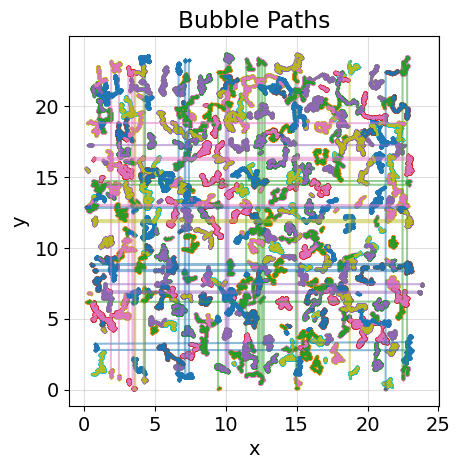

In [34]:
# scaling marker size with data range
x_span = df["x"].max() - df["x"].min()
y_span = df["y"].max() - df["y"].min()
scale = max(x_span, y_span)

base = 0.05        # tweak depending on figure size
marker_size = base * (10.0 / scale)

# All bubble paths
for bubble_id, group in df.groupby("id"):
    plt.plot(group["x"], group["y"], marker='o', markersize=.2, alpha=0.5)
    plt.scatter(group["x"], group["y"], s=2, alpha=1)


    # x marker at start point
    plt.plot(group["x"].iloc[0], group["y"].iloc[0], 'rx', markersize=marker_size**2)
   
    end_x, end_y = group["x"].iloc[-1], group["y"].iloc[-1]
    if bubble_id in disappearing_ids:
        plt.plot(end_x, end_y, marker="o", markersize=marker_size**2,
                 markerfacecolor="none", markeredgecolor="blue")
    else:
        plt.plot(end_x, end_y, marker="o", markersize=marker_size**2,
                 markeredgecolor="black", markerfacecolor="blue", markeredgewidth=0.5)

""" plt.xlim(15, 15.4)  
plt.ylim(3.5, 4) 
"""



plt.xlabel("x")
plt.ylabel("y")
plt.title("Bubble Paths")
plt.axis("square")
plt.grid(alpha=0.4)
#plt.savefig("/Users/conorkirby/projects/python/Capstone/Figures/bubble_paths_unfixed.png", dpi=300)
plt.show()



# x where starts, open circle when finish, closed circle --------------------------------------------
# make sure square and not stretching data, same scale on both axis ---------------------------------
# deal with periodic boundary conditions ------------------------------------------------------------
# mark beginning and end of each path, bubble  disappearance ----------------------------------------
# run for entire simulation length ------------------------------------------------------------------
# Run a comparison of gaussian with same number of data steps ---------------------------------------
# display linepoints as dots not connected lines, plus small line to show direction -----------------
# for simulation, histogram of changes in position, x and y separately like in file stefan sent on
# both for gaussian and bubble data, use log return, follow document, ln(x(t+dt)/x(t))

# for gaussian simulation, plot distance from origin as a function of time, both x and y ----------------
# plot the square of the distance as it is linear in time, mean squared displacement --------------------
# slope  depends on simulation and the parameters I set -------------------------------------------------
# how????

In [35]:
# Checks to rule out false data

# Looking for weird jumps
# bubble_id is the bubble identifier, g is the group of rows for that bubble

for bubble_id, g in df.groupby("id"):
    diffs = g[["x","y"]].diff().abs()
    if (diffs > 5).any().any():   # threshold depends on your scale
        print(f"Bubble {bubble_id} has a big jump: at {diffs[diffs > 5].stack().index.tolist()}")
        


# example line 15700:  85  22.434557  15.664212  0.081802   6.142216  2 ..... bubble 85 has a big jump 0 - 22 in y

Bubble 3 has a big jump: at [(395056, 'y'), (501803, 'y'), (530662, 'y')]
Bubble 17 has a big jump: at [(178938, 'y'), (404196, 'y'), (501806, 'y'), (538671, 'y'), (565357, 'y')]
Bubble 59 has a big jump: at [(82432, 'y')]
Bubble 74 has a big jump: at [(133706, 'y'), (256768, 'y'), (307652, 'y')]
Bubble 97 has a big jump: at [(90420, 'x'), (181930, 'x')]
Bubble 102 has a big jump: at [(341360, 'y')]
Bubble 108 has a big jump: at [(39083, 'x')]
Bubble 110 has a big jump: at [(501432, 'y')]
Bubble 151 has a big jump: at [(364981, 'y'), (365168, 'y'), (367573, 'y')]
Bubble 232 has a big jump: at [(315977, 'x')]
Bubble 241 has a big jump: at [(146035, 'x'), (197689, 'x')]
Bubble 242 has a big jump: at [(108577, 'y')]
Bubble 245 has a big jump: at [(129118, 'y'), (363146, 'y')]
Bubble 249 has a big jump: at [(146039, 'y'), (611622, 'y')]
Bubble 257 has a big jump: at [(152858, 'y'), (597583, 'y')]
Bubble 266 has a big jump: at [(4665, 'x'), (77918, 'x'), (563318, 'x'), (566469, 'x'), (57649

In [38]:
# Parameters for correction
thresh = 10.0         # jump threshold
rescale = 22.360680   # box size

# Create corrected dataframe
df_corrected = df.copy()

# Apply periodic boundary correction to all bubbles
for bubble_id, g in df.groupby("id"):
    g = g.sort_values("timestep").copy()
    
    x = g["x"].to_numpy()
    y = g["y"].to_numpy()

    for i in range(1, len(x)):
        dx = x[i] - x[i-1]
        dy = y[i] - y[i-1]

        # X correction
        if abs(dx) > thresh:
            if dx > 0:
                x[i:] -= rescale
            else:
                x[i:] += rescale

        # Y correction
        if abs(dy) > thresh:
            if dy > 0:
                y[i:] -= rescale
            else:
                y[i:] += rescale

    # Update corrected positions in the master dataframe
    df_corrected.loc[g.index, "x"] = x
    df_corrected.loc[g.index, "y"] = y

print("Periodic boundary correction applied and df_corrected created.")

Periodic boundary correction applied and df_corrected created.


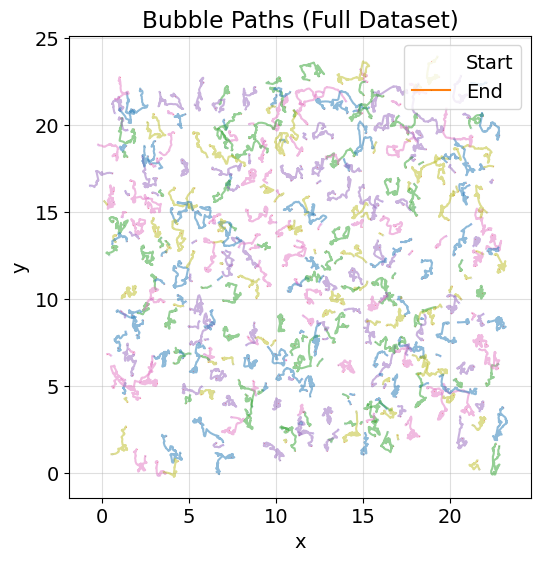

' plt.xlim(19.3, 20)  \nplt.ylim(2.5, 3.2) '

In [39]:
# Use the corrected dataframe for plotting
x_span = df_corrected["x"].max() - df_corrected["x"].min()
y_span = df_corrected["y"].max() - df_corrected["y"].min()
scale = max(x_span, y_span)

base = 0.5      # tweak depending on figure size
marker_size = base * (10.0 / scale)

plt.figure(figsize=(8,6))

# Plot paths with improved legend
for bubble_id, g in df_corrected.groupby("id"):
    g = g.sort_index().copy()
    x = g["x"].to_numpy()
    y = g["y"].to_numpy()

    # Plot path
    plt.plot(x, y, markersize=0.2, alpha=0.5) 
    plt.scatter(x, y, s=2, alpha=0.0005, color='grey')

    # Plot start point
    start = plt.plot(x[0], y[0], 'rx', markersize=marker_size**2, label='Start' if bubble_id == list(df_corrected.groupby("id").groups.keys())[0] else "")

    # Plot end point based on whether bubble disappears
    if bubble_id in disappearing_ids:
        end = plt.plot(x[-1], y[-1], marker="o", markersize=marker_size**2, 
                markerfacecolor="none", markeredgecolor="blue", 
                label='Disappearing End' if bubble_id == list(df_corrected.groupby("id").groups.keys())[0] else "")
    else:
        end = plt.plot(x[-1], y[-1], marker="o", markersize=marker_size**2,
                markeredgecolor="black", markerfacecolor="blue", markeredgewidth=0.5,
                label='End' if bubble_id == list(df_corrected.groupby("id").groups.keys())[0] else "")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Bubble Paths (Full Dataset)")
plt.axis("square")
""" plt.xlim(19.3, 20)  
plt.ylim(2.5, 3.2) """
plt.grid(alpha=0.4)
plt.legend(loc='upper right')
#plt.savefig("/Users/conorkirby/projects/python/Capstone/Figures/fullbubblepath(disappearing).png", dpi=300)
plt.show()

""" plt.xlim(15, 15.5)  
plt.ylim(3.5, 4.0) """ # for bubbletroubleshoot

""" plt.xlim(13.8, 15.3)
plt.ylim(3.0, 4.5) """ 

""" plt.xlim(0.7, 2.1)
plt.ylim(0.3, 1.7) """ # for bubblesamplefull nondisappear bubble path

""" plt.xlim(19.3, 20)  
plt.ylim(2.5, 3.2) """ # for bubblesamplefull disappearing bubble path


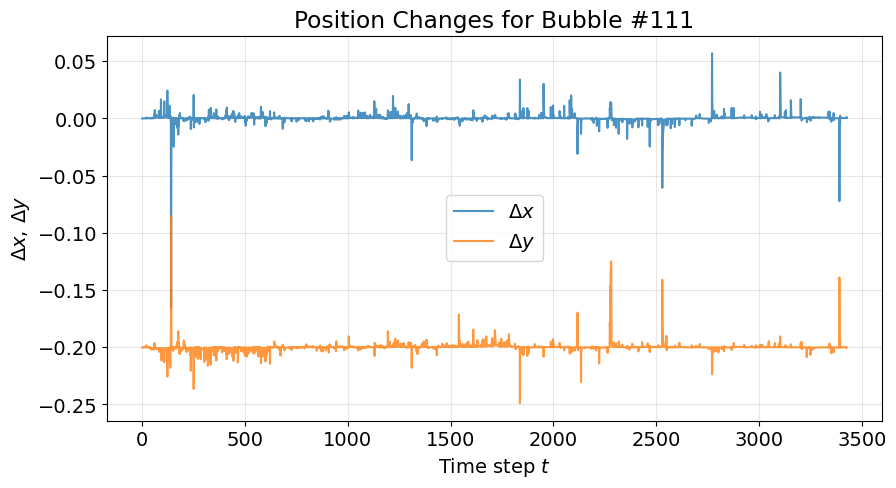

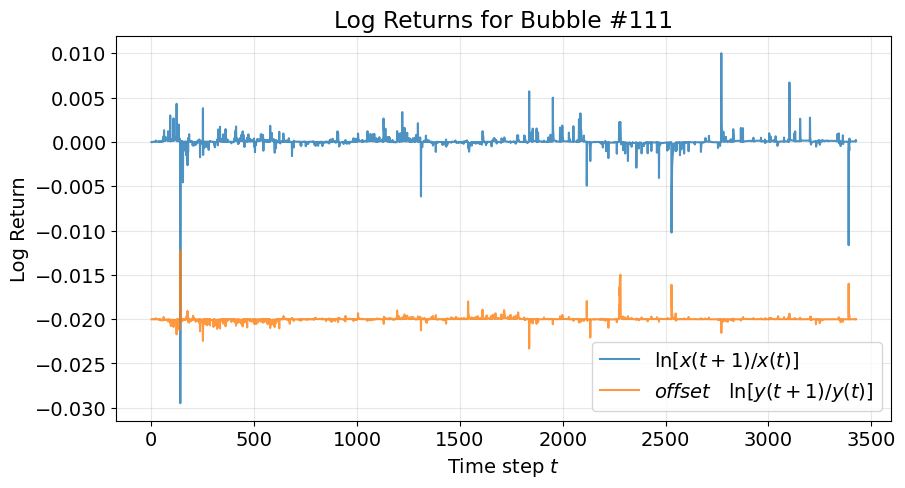

Bubble 111 statistics:
Number of steps: 3426
Mean $\Delta x$: 0.000192, Std: 0.004572
Mean $\Delta y$: 0.000069, Std: 0.004557
Mean log return $x$: 3.288311e-05, Std: 7.954151e-04
Mean log return $y$: 4.547513e-06, Std: 3.065993e-04


In [40]:
# Changes in positions in the x and y seperately of one bubble

bubble_id_to_analyze = np.random.choice(df_corrected["id"].unique())

bubble_data = df_corrected[df_corrected["id"] == bubble_id_to_analyze].sort_values("timestep").copy()

if len(bubble_data) > 1:
    # Use corrected positions directly
    x = bubble_data["x"].to_numpy()
    y = bubble_data["y"].to_numpy()

    # Calculate changes in position
    changes_x = np.diff(x)
    changes_y = np.diff(y)
    
    # Calculate log returns (shift to make positive)
    shifted_x = x + 1e-6
    shifted_y = y + 1e-6

    log_ret_x = np.log(shifted_x[1:] / shifted_x[:-1])
    log_ret_y = np.log(shifted_y[1:] / shifted_y[:-1])

    # Create step numbers
    step_numbers = np.arange(1, len(changes_x) + 1)
    
    # --- Plot position changes ---
    plt.figure(figsize=(10, 5))
    plt.plot(step_numbers, changes_x, label=r'$\Delta x$', alpha=0.8)
    plt.plot(step_numbers, changes_y - 0.2, label=r'$\Delta y$', alpha=0.8)
    plt.xlabel(r'Time step $t$')
    plt.ylabel(r'$\Delta x, \, \Delta y$')
    plt.title(rf'Position Changes for Bubble #{bubble_id_to_analyze}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    #plt.savefig(f"/Users/conorkirby/projects/python/Capstone/Figures/position_changes_bubble_{bubble_id_to_analyze}.png", dpi=300)
    plt.show()

    # --- Plot log returns ---
    plt.figure(figsize=(10, 5))
    plt.plot(step_numbers, log_ret_x, label=r'$\ln[x(t+1)/x(t)]$', alpha=0.8)
    plt.plot(step_numbers, log_ret_y - 0.02, label=r'$offset \quad \ln[y(t+1)/y(t)]$', alpha=0.8)
    plt.xlabel(r'Time step $t$')
    plt.ylabel(r'Log Return')
    plt.title(rf'Log Returns for Bubble #{bubble_id_to_analyze}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    #plt.savefig(f"/Users/conorkirby/projects/python/Capstone/Figures/log_returns_bubble_{bubble_id_to_analyze}.png", dpi=300)
    plt.show()

    # --- Print statistics ---
    print(fr"Bubble {bubble_id_to_analyze} statistics:")
    print(fr"Number of steps: {len(changes_x)}")
    print(fr"Mean $\Delta x$: {np.mean(changes_x):.6f}, Std: {np.std(changes_x):.6f}")
    print(fr"Mean $\Delta y$: {np.mean(changes_y):.6f}, Std: {np.std(changes_y):.6f}")
    print(fr"Mean log return $x$: {np.mean(log_ret_x):.6e}, Std: {np.std(log_ret_x):.6e}")
    print(fr"Mean log return $y$: {np.mean(log_ret_y):.6e}, Std: {np.std(log_ret_y):.6e}")

else:
    print(f"Bubble {bubble_id_to_analyze} not found or has insufficient data points")

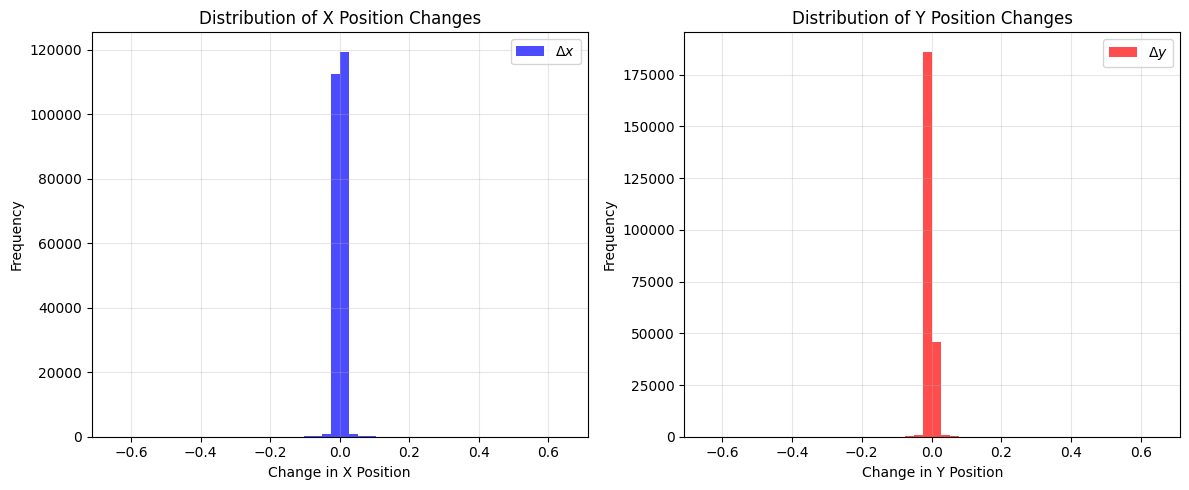

Total changes analyzed: 234268
Mean change in x (all bubbles): -0.000029
Mean change in y (all bubbles): 0.000003


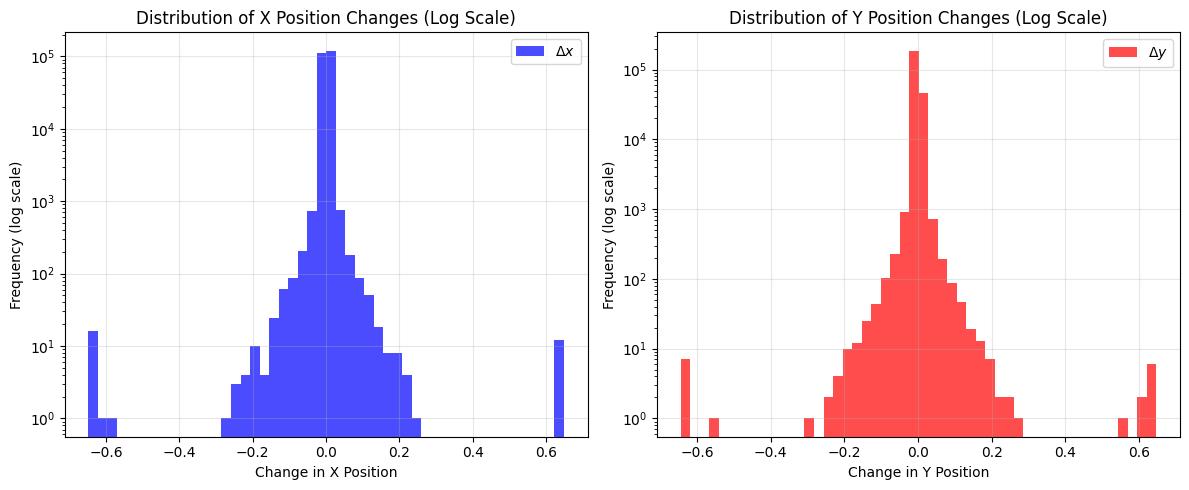

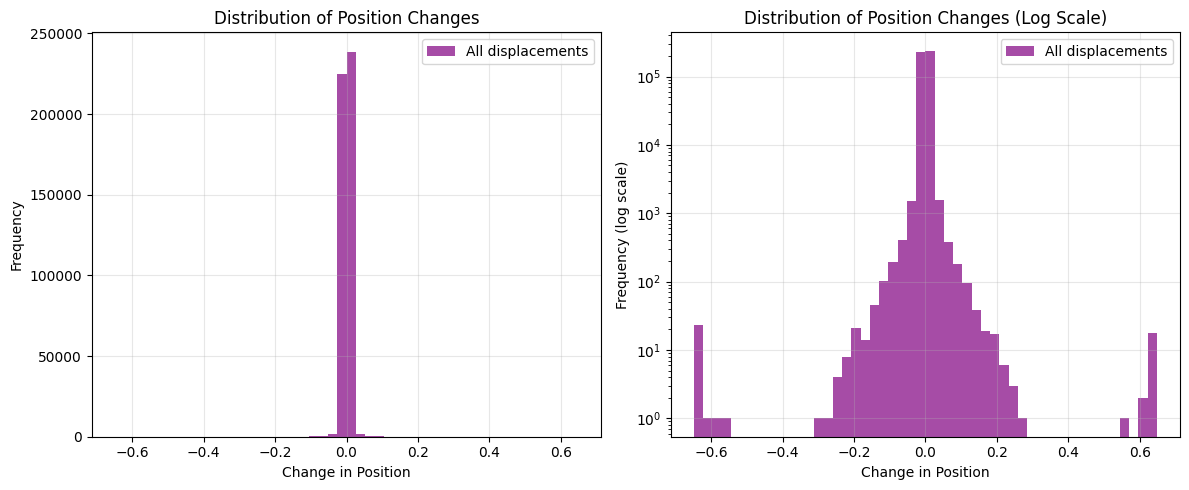

Total position changes analyzed: 468536
Mean change in position (all directions): -0.000013
Standard deviation of changes: 0.009725


In [22]:
# Collect all position changes from all bubbles
all_changes_x = []
all_changes_y = []

for bubble_id, g in df_corrected.groupby("id"):
    g = g.sort_values("timestep").copy()
    
    if len(g) < 2:  # Need at least 2 points to calculate changes
        continue
        
    # Use corrected positions directly
    x = g["x"].to_numpy()
    y = g["y"].to_numpy()
    
    changes_x = np.diff(x)
    changes_y = np.diff(y)
    
    all_changes_x.extend(changes_x)
    all_changes_y.extend(changes_y)

# Plot histogram of all changes
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(all_changes_x, bins=50, alpha=0.7, label=r'$\Delta x$', color='blue')
plt.xlabel('Change in X Position')
plt.ylabel('Frequency')
plt.title('Distribution of X Position Changes')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(all_changes_y, bins=50, alpha=0.7, label=r'$\Delta y$', color='red')
plt.xlabel('Change in Y Position')
plt.ylabel('Frequency')
plt.title('Distribution of Y Position Changes')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
#plt.savefig("/Users/conorkirby/projects/python/Capstone/Figures/bubble_displacement_histograms.png", dpi=300)
plt.show()

print(f"Total changes analyzed: {len(all_changes_x)}")
print(f"Mean change in x (all bubbles): {np.mean(all_changes_x):.6f}")
print(f"Mean change in y (all bubbles): {np.mean(all_changes_y):.6f}")


# Plot the same histograms with log scale
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(all_changes_x, bins=50, alpha=0.7, label=r'$\Delta x$', color='blue', log=True)
plt.xlabel('Change in X Position')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of X Position Changes (Log Scale)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(all_changes_y, bins=50, alpha=0.7, label=r'$\Delta y$', color='red', log=True)
plt.xlabel('Change in Y Position')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of Y Position Changes (Log Scale)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
#plt.savefig("/Users/conorkirby/projects/python/Capstone/Figures/bubble_displacement_histograms_log.png", dpi=300)
plt.show()


# Combine x and y changes for overall displacement distribution
all_changes = np.concatenate([all_changes_x, all_changes_y])

plt.figure(figsize=(12, 5))

# Linear scale histogram
plt.subplot(1, 2, 1)
plt.hist(all_changes, bins=50, alpha=0.7, color='purple', label='All displacements')
plt.xlabel('Change in Position')
plt.ylabel('Frequency')
plt.title('Distribution of Position Changes')
plt.grid(True, alpha=0.3)
plt.legend()

# Log scale histogram
plt.subplot(1, 2, 2)
plt.hist(all_changes, bins=50, alpha=0.7, color='purple', label='All displacements', log=True)
plt.xlabel('Change in Position')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of Position Changes (Log Scale)')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
#plt.savefig("/Users/conorkirby/projects/python/Capstone/Figures/bubble_displacement_histograms_combined.png", dpi=300)
plt.show()

print(f"Total position changes analyzed: {len(all_changes)}")
print(f"Mean change in position (all directions): {np.mean(all_changes):.6f}")
print(f"Standard deviation of changes: {np.std(all_changes):.6f}")


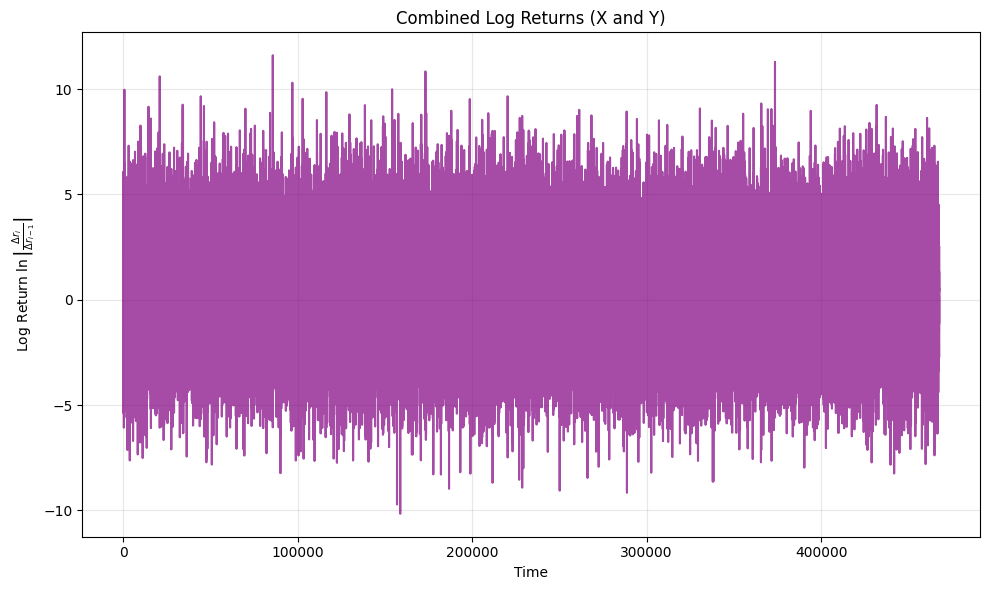

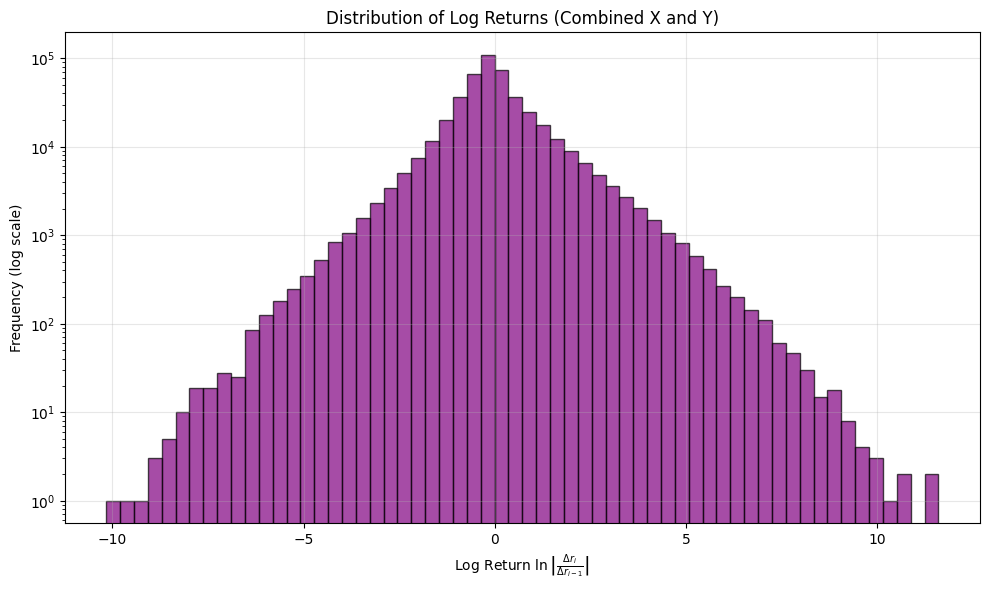

Total log returns: 467668
Mean: 1.327982e-06, Std: 1.264721e+00


In [23]:
# Calculate log returns for combined position changes
# Avoid log(0) and handle both positive and negative changes
eps = 1e-9

# Convert lists to numpy arrays first
all_changes_x = np.array(all_changes_x, dtype=float)
all_changes_y = np.array(all_changes_y, dtype=float)

# Filter out near-zero values to avoid log singularities
mask_x = np.abs(all_changes_x) > eps
mask_y = np.abs(all_changes_y) > eps

valid_changes_x = all_changes_x[mask_x]
valid_changes_y = all_changes_y[mask_y]

# Calculate consecutive log returns
if len(valid_changes_x) > 1:
    log_returns_x = np.log(np.abs(valid_changes_x[1:]) / np.abs(valid_changes_x[:-1]))
else:
    log_returns_x = np.array([])

if len(valid_changes_y) > 1:
    log_returns_y = np.log(np.abs(valid_changes_y[1:]) / np.abs(valid_changes_y[:-1]))
else:
    log_returns_y = np.array([])

log_returns = np.concatenate([log_returns_x, log_returns_y])

# plot combines x and y versus time
plt.figure(figsize=(10, 6))
plt.plot(log_returns, alpha=0.7, color='purple')
plt.xlabel('Time')
plt.ylabel(r'Log Return $\ln\left|\frac{\Delta r_i}{\Delta r_{i-1}}\right|$')
plt.title('Combined Log Returns (X and Y)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot combined histogram
plt.figure(figsize=(10, 6))
plt.hist(log_returns, bins=60, alpha=0.7, color='purple', edgecolor='black')
plt.xlabel(r'Log Return $\ln\left|\frac{\Delta r_i}{\Delta r_{i-1}}\right|$')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of Log Returns (Combined X and Y)')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total log returns: {len(log_returns)}")
print(f"Mean: {np.mean(log_returns):.6e}, Std: {np.std(log_returns):.6e}")


# Varying dt Values Analysis... plus Correlation Functions

This section explores the impact of different time steps (dt) on bubble displacements and log returns. The analysis helps understand how the choice of time interval affects the observed bubble dynamics and statistical properties.

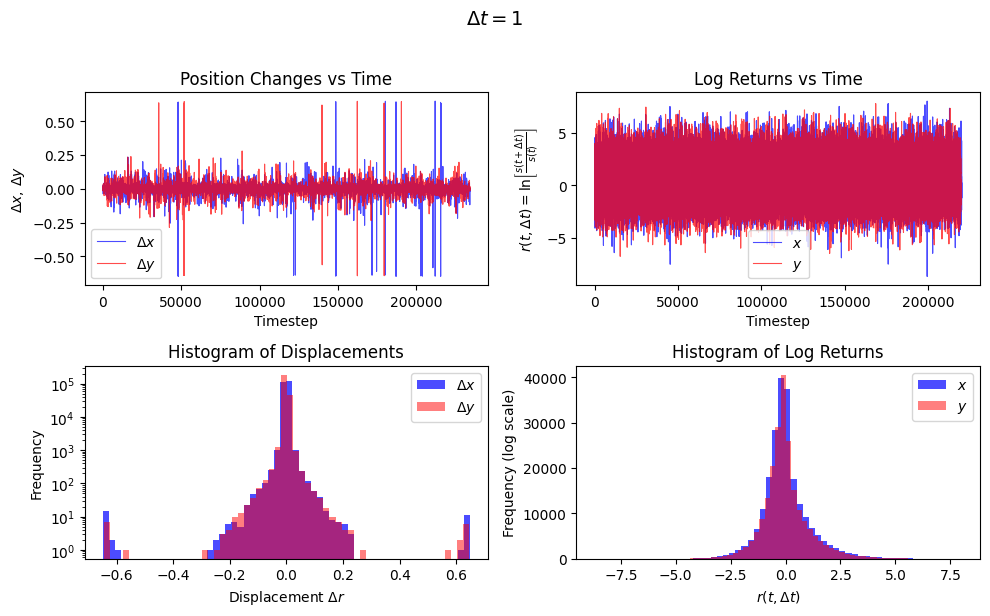

$\Delta t = 1$:
  total samples  Δx=234268, Δy=234268
  mean(Δx)=-0.000029, mean(Δy)=0.000003
  var(Δx)=0.000106, var(Δy)=0.000083
  mean(log_ret_x)=-5.187894e-07, var(log_ret_x)=1.128302e+00
  mean(log_ret_y)=3.346245e-06, var(log_ret_y)=1.112883e+00



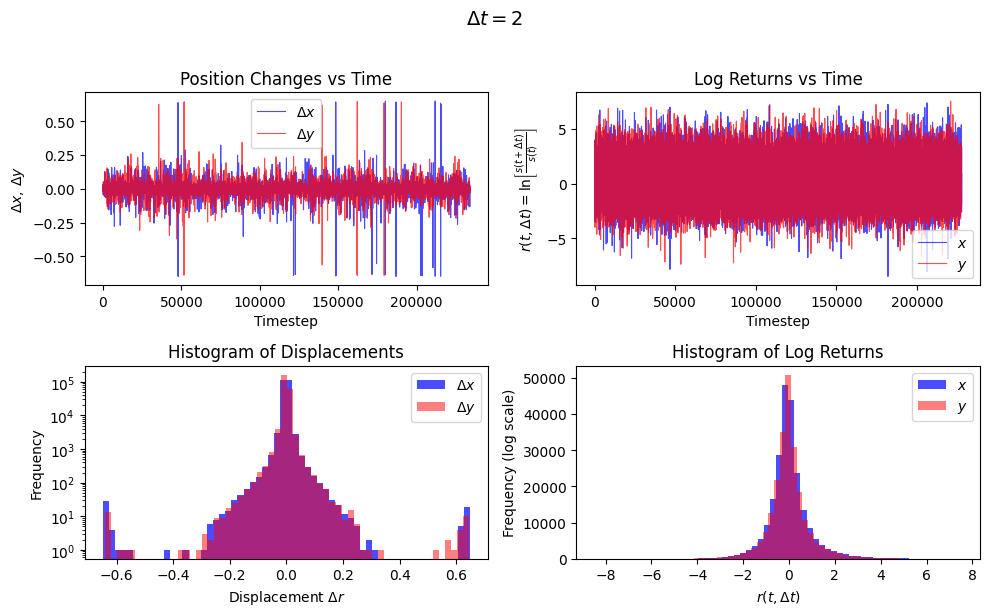

$\Delta t = 2$:
  total samples  Δx=233868, Δy=233868
  mean(Δx)=-0.000056, mean(Δy)=0.000006
  var(Δx)=0.000253, var(Δy)=0.000210
  mean(log_ret_x)=4.724087e-06, var(log_ret_x)=7.814856e-01
  mean(log_ret_y)=2.886740e-06, var(log_ret_y)=7.824627e-01



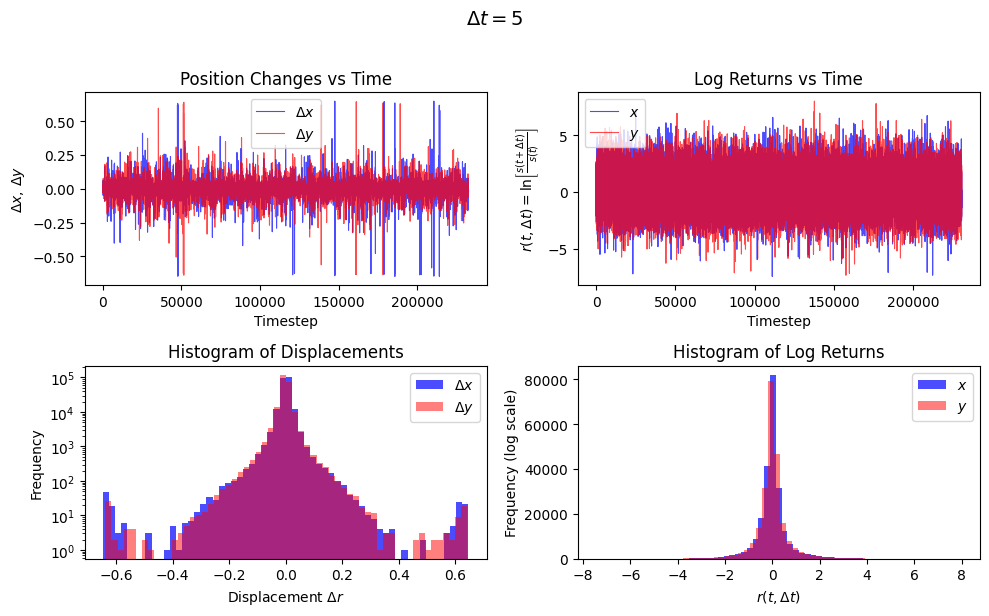

$\Delta t = 5$:
  total samples  Δx=232668, Δy=232668
  mean(Δx)=-0.000126, mean(Δy)=0.000013
  var(Δx)=0.000809, var(Δy)=0.000722
  mean(log_ret_x)=2.495168e-06, var(log_ret_x)=4.872228e-01
  mean(log_ret_y)=1.836891e-06, var(log_ret_y)=4.894358e-01



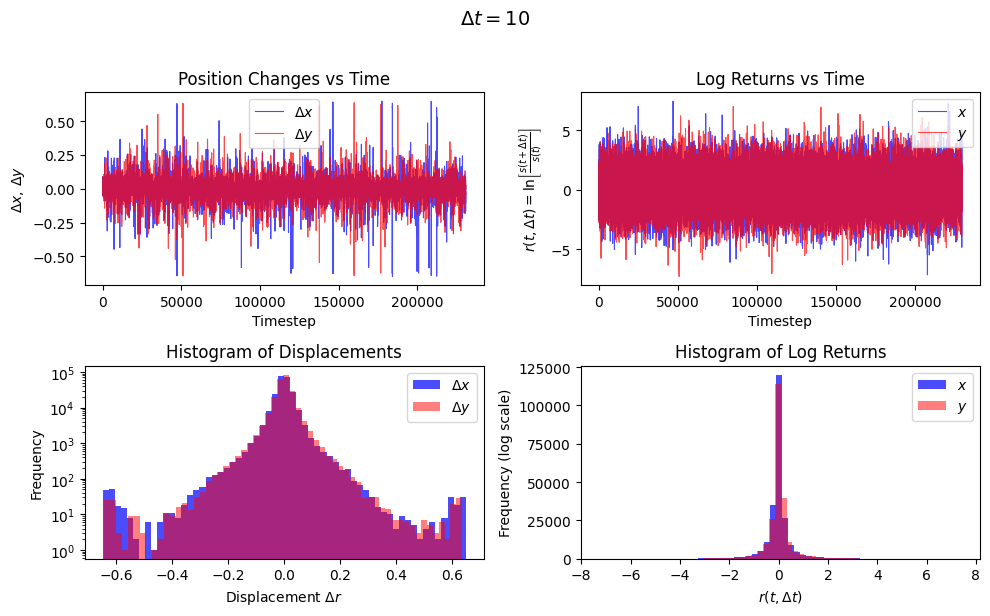

$\Delta t = 10$:
  total samples  Δx=230668, Δy=230668
  mean(Δx)=-0.000227, mean(Δy)=0.000037
  var(Δx)=0.001972, var(Δy)=0.001845
  mean(log_ret_x)=3.718397e-06, var(log_ret_x)=3.160059e-01
  mean(log_ret_y)=3.188522e-06, var(log_ret_y)=3.182939e-01



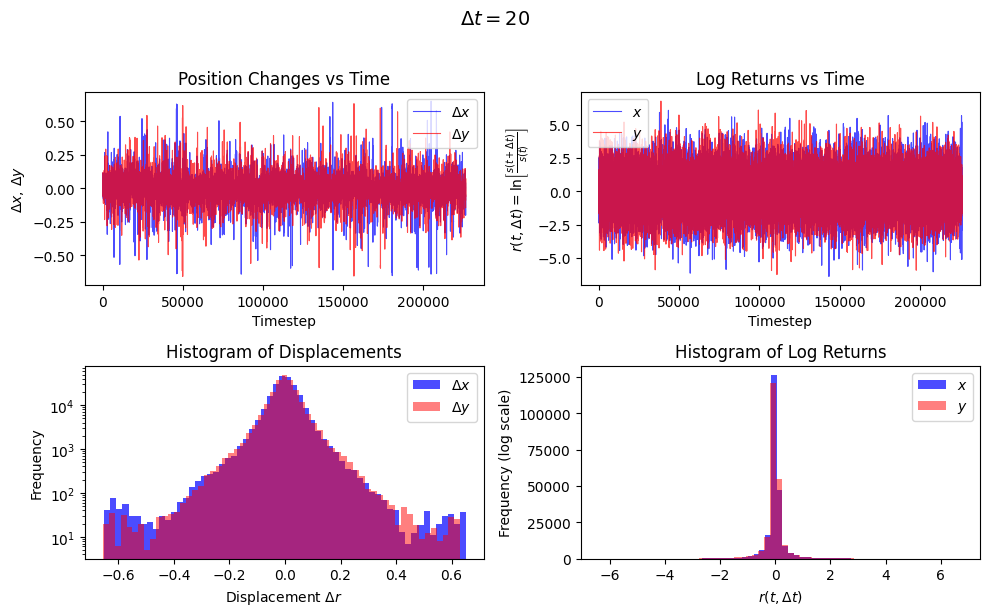

$\Delta t = 20$:
  total samples  Δx=226679, Δy=226679
  mean(Δx)=-0.000393, mean(Δy)=0.000099
  var(Δx)=0.004865, var(Δy)=0.004714
  mean(log_ret_x)=5.393830e-06, var(log_ret_x)=2.137087e-01
  mean(log_ret_y)=1.710354e-06, var(log_ret_y)=2.125207e-01



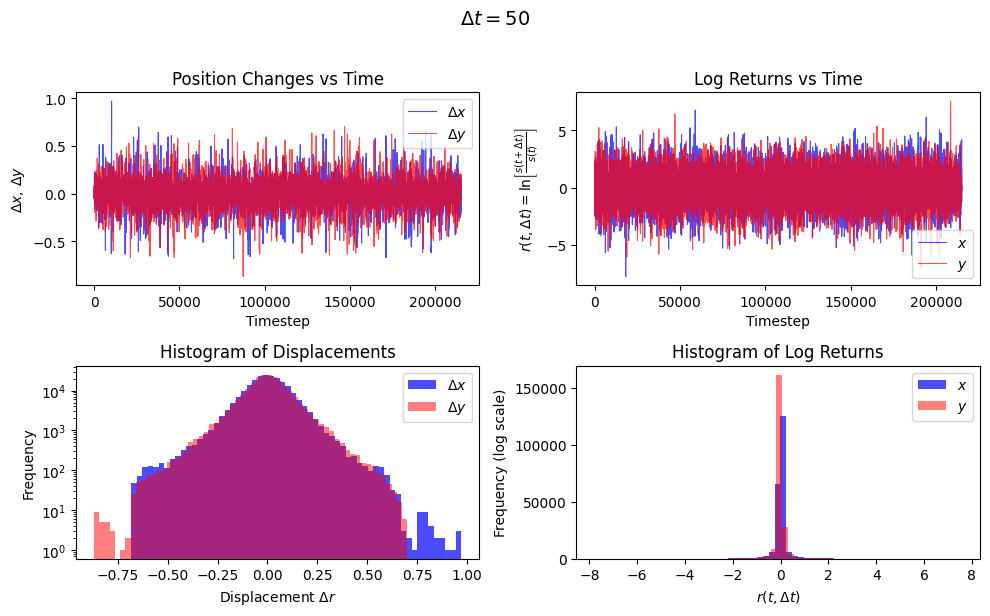

$\Delta t = 50$:
  total samples  Δx=215213, Δy=215213
  mean(Δx)=-0.000685, mean(Δy)=0.000207
  var(Δx)=0.015619, var(Δy)=0.015949
  mean(log_ret_x)=1.218451e-05, var(log_ret_x)=1.217386e-01
  mean(log_ret_y)=8.121811e-07, var(log_ret_y)=1.214129e-01



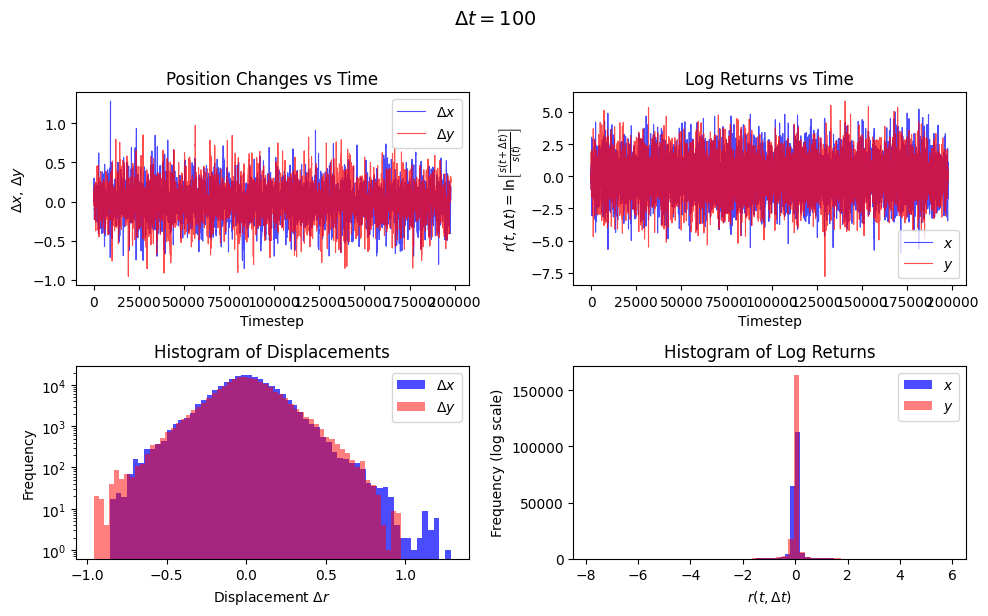

$\Delta t = 100$:
  total samples  Δx=197822, Δy=197822
  mean(Δx)=-0.000908, mean(Δy)=0.000594
  var(Δx)=0.035416, var(Δy)=0.038908
  mean(log_ret_x)=3.003120e-06, var(log_ret_x)=8.605792e-02
  mean(log_ret_y)=8.333478e-06, var(log_ret_y)=8.093990e-02



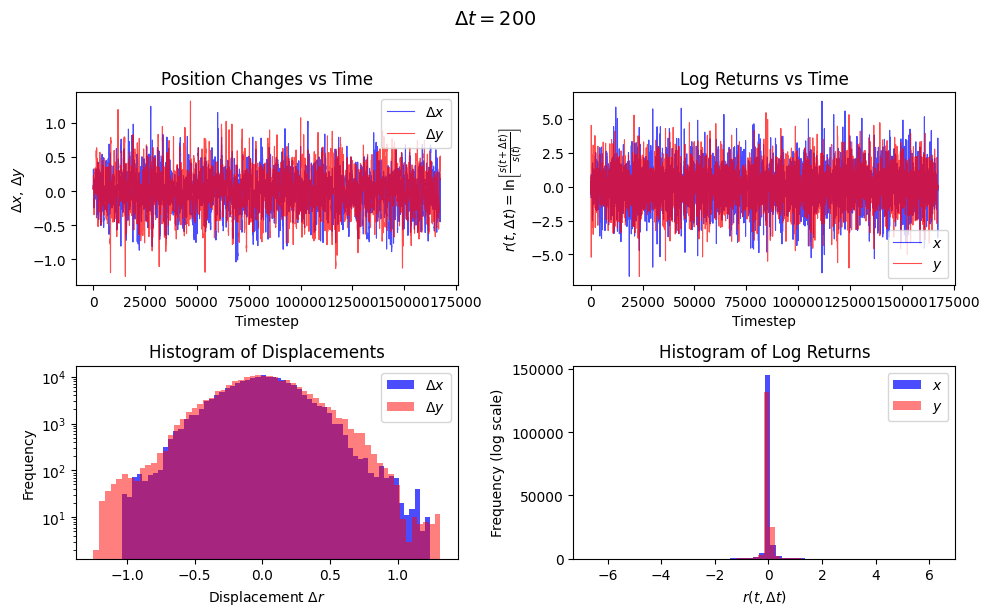

$\Delta t = 200$:
  total samples  Δx=167525, Δy=167525
  mean(Δx)=-0.002350, mean(Δy)=0.002795
  var(Δx)=0.070179, var(Δy)=0.082807
  mean(log_ret_x)=4.678849e-06, var(log_ret_x)=6.360047e-02
  mean(log_ret_y)=1.499096e-05, var(log_ret_y)=5.424706e-02



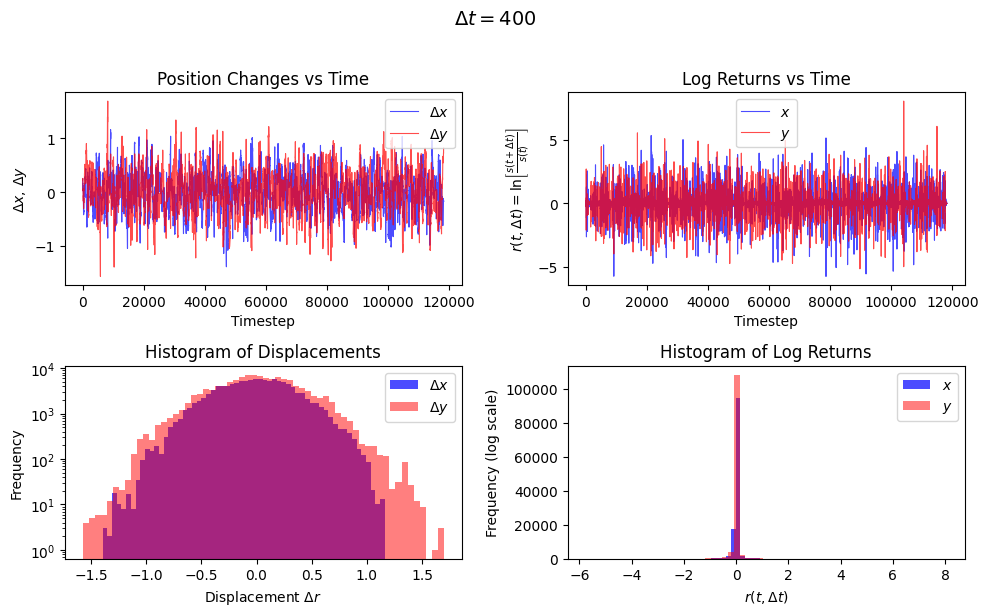

$\Delta t = 400$:
  total samples  Δx=118219, Δy=118219
  mean(Δx)=-0.003834, mean(Δy)=0.014150
  var(Δx)=0.119867, var(Δy)=0.153282
  mean(log_ret_x)=-2.811799e-06, var(log_ret_x)=4.424039e-02
  mean(log_ret_y)=1.083990e-05, var(log_ret_y)=4.455975e-02



In [24]:
import numpy as np
import matplotlib.pyplot as plt

dt_values = [1, 2, 5, 10, 20, 50, 100, 200, 400]

# Small offset to avoid log(0)
eps = 1e-9

for dt in dt_values:
    all_dx, all_dy = [], []

    # --- Compute displacements for each bubble ---
    for bubble_id, g in df_corrected.groupby("id"):
        g = g.sort_values("timestep").copy()
        x, y = g["x"].to_numpy(), g["y"].to_numpy()

        if len(x) <= dt:
            continue

        dx_dt = x[dt:] - x[:-dt]
        dy_dt = y[dt:] - y[:-dt]

        all_dx.extend(dx_dt)
        all_dy.extend(dy_dt)

    all_dx = np.array(all_dx)
    all_dy = np.array(all_dy)

    # --- Magnitude filtering and safe log conversion ---
    mag_dx = np.abs(all_dx) + eps
    mag_dy = np.abs(all_dy) + eps

    mask_x = mag_dx > 1e-4
    mask_y = mag_dy > 1e-4

    mag_dx = mag_dx[mask_x]
    mag_dy = mag_dy[mask_y]

    # --- Compute log returns using same formalism as econophysics ---
    # r(t) = ln[ s(t+Δt)/s(t) ]
    # Here using magnitudes since positions can cross zero
    log_ret_x = np.log(mag_dx[1:] / mag_dx[:-1])
    log_ret_y = np.log(mag_dy[1:] / mag_dy[:-1])

    time = np.arange(len(all_dx))

    # --- Create 2×2 panel plot per Δt ---
    fig, axs = plt.subplots(2, 2, figsize=(10, 6))
    fig.suptitle(rf"$\Delta t = {dt}$", fontsize=14, y=1.02)

    # (1) Δx and Δy vs time
    axs[0, 0].plot(time, all_dx, lw=0.8, alpha=0.7, label=r"$\Delta x$", color='blue')
    axs[0, 0].plot(time, all_dy, lw=0.8, alpha=0.7, label=r"$\Delta y$", color='red')
    axs[0, 0].set_title("Position Changes vs Time")
    axs[0, 0].set_xlabel("Timestep")
    axs[0, 0].set_ylabel(r"$\Delta x,\, \Delta y$")
    axs[0, 0].legend()

    # (2) Log returns vs time
    axs[0, 1].plot(time[:len(log_ret_x)], log_ret_x, lw=0.8, alpha=0.7, color='blue', label=r"$x$")
    axs[0, 1].plot(time[:len(log_ret_y)], log_ret_y, lw=0.8, alpha=0.7, color='red', label=r"$y$")
    axs[0, 1].set_title("Log Returns vs Time")
    axs[0, 1].set_xlabel("Timestep")
    axs[0, 1].set_ylabel(r"$r(t,\Delta t) = \ln\!\left[\frac{s(t+\Delta t)}{s(t)}\right]$")
    axs[0, 1].legend()

    # (3) Histogram of Δx and Δy
    axs[1, 0].hist(all_dx, bins=60, alpha=0.7, color='blue', label=r'$\Delta x$', log=True)
    axs[1, 0].hist(all_dy, bins=60, alpha=0.5, color='red', label=r'$\Delta y$', log=True)
    axs[1, 0].set_title("Histogram of Displacements")
    axs[1, 0].set_xlabel(r"Displacement $\Delta r$")
    axs[1, 0].set_ylabel("Frequency")
    axs[1, 0].legend()

    # (4) Histogram of log returns
    axs[1, 1].hist(log_ret_x, bins=60, alpha=0.7, color='blue', label=r'$x$')
    axs[1, 1].hist(log_ret_y, bins=60, alpha=0.5, color='red', label=r'$y$')
    axs[1, 1].set_title("Histogram of Log Returns")
    axs[1, 1].set_xlabel(r"$r(t,\Delta t)$")
    axs[1, 1].set_ylabel("Frequency (log scale)")
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

    # --- Summary statistics ---
    print(f"$\\Delta t = {dt}$:")
    print(f"  total samples  Δx={len(all_dx)}, Δy={len(all_dy)}")
    print(f"  mean(Δx)={np.mean(all_dx):.6f}, mean(Δy)={np.mean(all_dy):.6f}")
    print(f"  var(Δx)={np.var(all_dx):.6f}, var(Δy)={np.var(all_dy):.6f}")
    print(f"  mean(log_ret_x)={np.mean(log_ret_x):.6e}, var(log_ret_x)={np.var(log_ret_x):.6e}")
    print(f"  mean(log_ret_y)={np.mean(log_ret_y):.6e}, var(log_ret_y)={np.var(log_ret_y):.6e}\n")

$$\Delta t = 1: n=468536, mean=-0.00001, var=0.00009
$$\Delta t = 5: n=465336, mean=-0.00006, var=0.00077
$$\Delta t = 20: n=453358, mean=-0.00015, var=0.00479
$$\Delta t = 100: n=395644, mean=-0.00016, var=0.03716
$$\Delta t = 400: n=236438, mean=0.00516, var=0.13666
$$\Delta t = 700: n=124376, mean=0.02266, var=0.21498


/var/folders/l1/x0797x3512d9sktcpm47npbh0000gn/T/ipykernel_50336/3772800400.py:86: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[idx].set_ylim(0, 1e6)  # Fixed y-axis range (log scale)


Log-return Δt = 1: n=468536, mean=-4.05293e-06, var=3.99054e-05
Log-return Δt = 5: n=465336, mean=-1.76805e-05, var=1.91530e-04
Log-return Δt = 20: n=453358, mean=-6.30542e-05, var=7.13997e-04
Log-return Δt = 100: n=395644, mean=-2.70469e-04, var=2.91229e-03
Log-return Δt = 400: n=236438, mean=-2.24927e-03, var=7.92245e-03
Log-return Δt = 700: n=124376, mean=-2.85994e-03, var=1.26036e-02


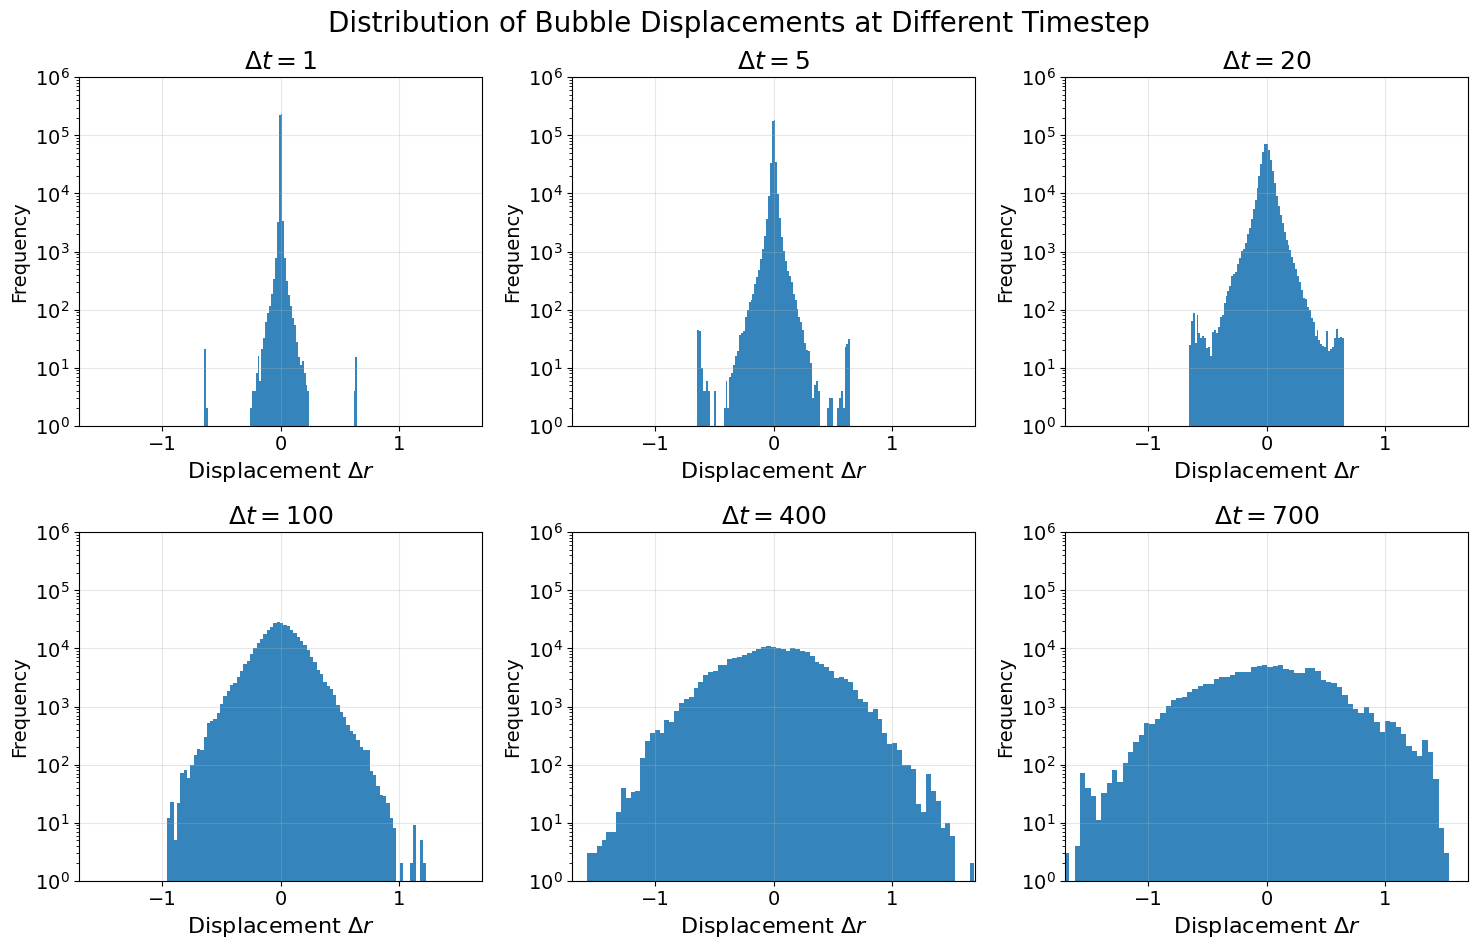

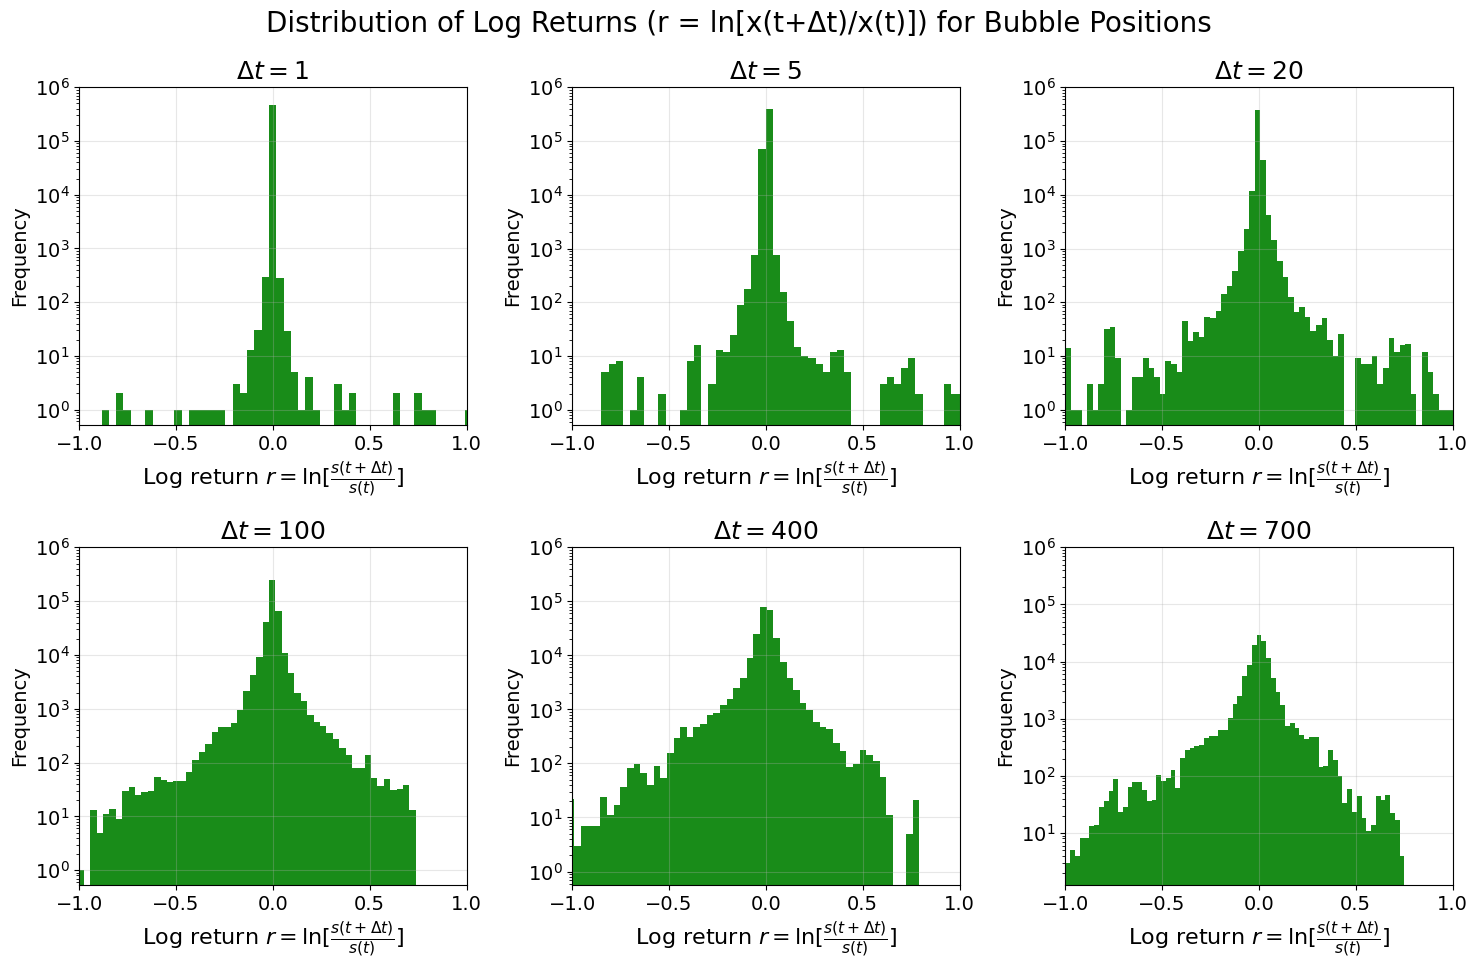

In [26]:
# Time intervals to analyse
dt_values = [1, 5, 20, 100, 400, 700]

# Update font sizes
plt.rcParams.update({'font.size': 14})  

# Update title font size separately
# plt.rcParams.update({'axes.titlesize': 30}) wrong title


# 1. DISTRIBUTION OF DISPLACEMENTS
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()
plt.suptitle('Distribution of Bubble Displacements at Different Timestep', fontsize=20, y=0.95)

for idx, dt in enumerate(dt_values):
    all_dx, all_dy = [], []

    for bubble_id, g in df_corrected.groupby("id"):
        g = g.sort_values("timestep").copy()
        x, y = g["x"].to_numpy(), g["y"].to_numpy()

        if len(x) <= dt:
            continue

        dx_dt = x[dt:] - x[:-dt] 
        dy_dt = y[dt:] - y[:-dt]

        all_dx.extend(dx_dt)
        all_dy.extend(dy_dt)

    # Combine both directions
    all_disp = np.concatenate([all_dx, all_dy])
    axs[idx].hist(all_disp, bins=80, alpha=0.9)
    axs[idx].set_title(rf"$\Delta t = {dt}$", fontsize=18)
    axs[idx].grid(alpha=0.3)
    axs[idx].set_yscale('log')
    axs[idx].set_xlim(-1.7, 1.7)  # Fixed x-axis range
    axs[idx].set_ylim(1, 1e6)
    print(f"$$\Delta t = {dt}: n={len(all_disp)}, mean={np.mean(all_disp):.5f}, var={np.var(all_disp):.5f}")

for ax in axs:
    ax.set_xlabel(r"Displacement $\Delta r$", fontsize=16)
    ax.set_ylabel("Frequency")

plt.tight_layout(rect=[0, 0, 1, 0.98])
# plt.savefig("/Users/conorkirby/projects/python/Capstone/Figures/bubble_displacement_dt_1_400.png", dpi=300, bbox_inches='tight')

# 2. DISTRIBUTION OF LOG RETURNS
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel() # flatten 2D array of axes for easy indexing
plt.suptitle('Distribution of Log Returns (r = ln[x(t+Δt)/x(t)]) for Bubble Positions', fontsize=20, y=0.97)

for idx, dt in enumerate(dt_values):
    log_ret_x, log_ret_y = [], []

    for bubble_id, g in df_corrected.groupby("id"):
        g = g.sort_values("timestep").copy()
        x, y = g["x"].to_numpy(), g["y"].to_numpy()

        if len(x) <= dt:
            continue
        
        # Small epsilon prevents log(0) and division by zero
        eps = 1e-6
        valid_x = (np.abs(x[:-dt]) > eps)
        valid_y = (np.abs(y[:-dt]) > eps)
        
        # Log returns
        r_x = np.log((x[dt:]) / (x[:-dt]))
        r_y = np.log((y[dt:]) / (y[:-dt]))

        log_ret_x.extend(r_x[valid_x]) 
        log_ret_y.extend(r_y[valid_y])

    # Combine both for better statistics
    all_r = np.concatenate([log_ret_x, log_ret_y])

    axs[idx].hist(all_r, bins=80, alpha=0.9, color='green')
    axs[idx].set_title(rf"$\Delta t = {dt}$", fontsize=18)
    axs[idx].grid(alpha=0.3)
    axs[idx].set_yscale('log')
    
    # Set fixed ranges for all plots
    axs[idx].set_xlim(-1, 1)  # Fixed x-axis range
    axs[idx].set_ylim(0, 1e6)  # Fixed y-axis range (log scale)

    mean_r, var_r = np.mean(all_r), np.var(all_r)
    print(f"Log-return Δt = {dt}: n={len(all_r)}, mean={mean_r:.5e}, var={var_r:.5e}")

for ax in axs:
    ax.set_xlabel(r"Log return $r = \ln[\frac{s(t+\Delta t)}{s(t)}]$", fontsize=16)
    ax.set_ylabel("Frequency")

plt.tight_layout(rect=[0, 0, 1, 0.99])
#plt.savefig("/Users/conorkirby/projects/python/Capstone/Figures/bubble_log_return_dt_1_400.png", dpi=300, bbox_inches='tight')

plt.show()


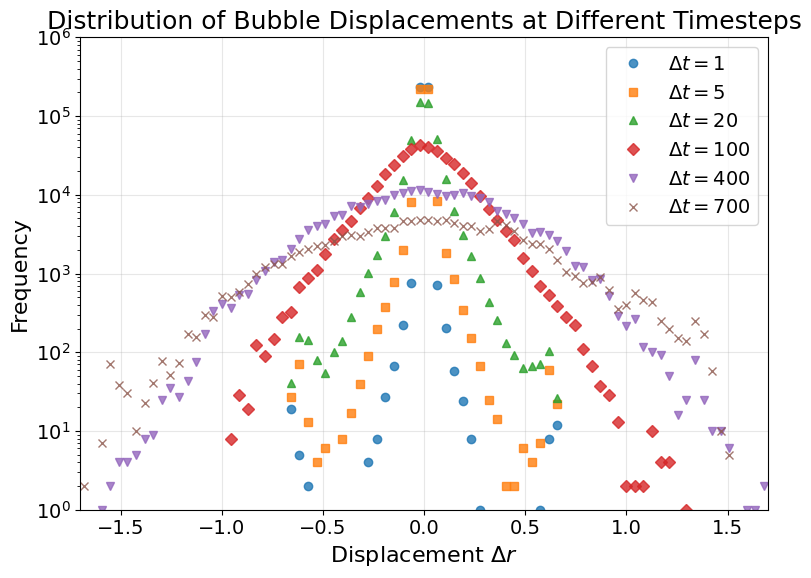

In [28]:
dt_values = [1, 5, 20, 100, 400, 700]

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8, 6))

markers = ['o', 's', '^', 'D', 'v', 'x']  # marker styles for each dt

for idx, dt in enumerate(dt_values):
    all_dx, all_dy = [], []

    for bubble_id, g in df_corrected.groupby("id"):
        g = g.sort_values("timestep").copy()
        x, y = g["x"].to_numpy(), g["y"].to_numpy()

        if len(x) <= dt:
            continue

        dx_dt = x[dt:] - x[:-dt]
        dy_dt = y[dt:] - y[:-dt]

        all_dx.extend(dx_dt)
        all_dy.extend(dy_dt)

    all_disp = np.concatenate([all_dx, all_dy])

    # Compute histogram values manually (no bars)
    counts, bin_edges = np.histogram(all_disp, bins=80, range=(-1.7, 1.7))
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    plt.plot(bin_centers, counts, marker=markers[idx % len(markers)], 
             linestyle='none', label=rf'$\Delta t = {dt}$', alpha=0.8)

# Axes settings
plt.yscale('log')
plt.xlim(-1.7, 1.7)
plt.ylim(1, 1e6)
plt.xlabel(r"Displacement $\Delta r$", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.title("Distribution of Bubble Displacements at Different Timesteps", fontsize=18)
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
#plt.savefig("/Users/conorkirby/projects/python/Capstone/Figures/bubble_displacement_overlay.png",
#            dpi=300, bbox_inches='tight')
plt.show()




how do we analyse correlation

# Average Bubble Area Over Time
Comparing the difference between analytic and our approximation method

Slope of average area vs timestep: 0.003989
Initial average area <A_0>: 1.000000


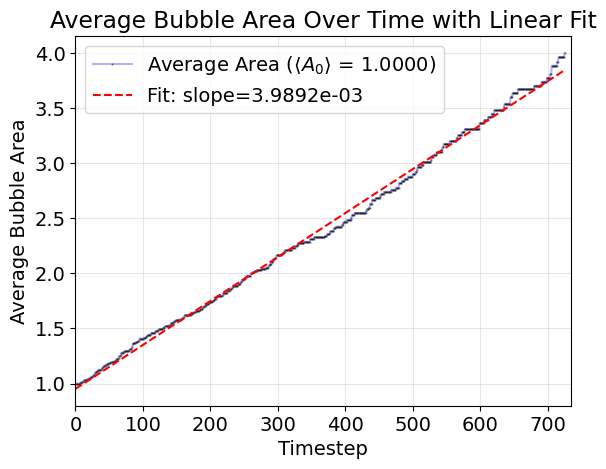

In [ ]:
from scipy.stats import linregress

# Analysing the average area of the bubbles over time
avg_area_per_timestep = df_corrected.groupby("timestep")["area"].apply(lambda x: np.mean(np.pi * x**2)) 

# Fit a line to the average area over time and get the slope
slope, intercept, r_value, p_value, std_err = linregress(avg_area_per_timestep.index, avg_area_per_timestep.values)
print(f"Slope of average area vs timestep: {slope:.6f}")

# Get initial average area
A_0 = avg_area_per_timestep.iloc[0]
print(f"Initial average area <A_0>: {A_0:.6f}")

# Plot the fitted line

plt.plot(avg_area_per_timestep.index, avg_area_per_timestep.values, marker='o', markersize=0.75, linestyle='-', alpha=0.3, color='blue', markerfacecolor='black', markeredgecolor='black', label=f'Average Area ($\\langle A_0 \\rangle$ = {A_0:.4f})')
plt.plot(avg_area_per_timestep.index, intercept + slope * avg_area_per_timestep.index, 'r--', label=f'Fit: slope={slope:.4e}')
plt.xlabel("Timestep")
plt.ylabel("Average Bubble Area")
plt.title("Average Bubble Area Over Time with Linear Fit")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, avg_area_per_timestep.index.max()+10)
#plt.savefig("/Users/conorkirby/projects/python/Capstone/Figures/average_bubble_area_over_time.png", dpi=300)
plt.show()


1.0000000107860723
Box area: 408.16
Assumed liquid fraction: 0.02
Mean percent error: -0.00%
Standard deviation of percent error: 0.00%


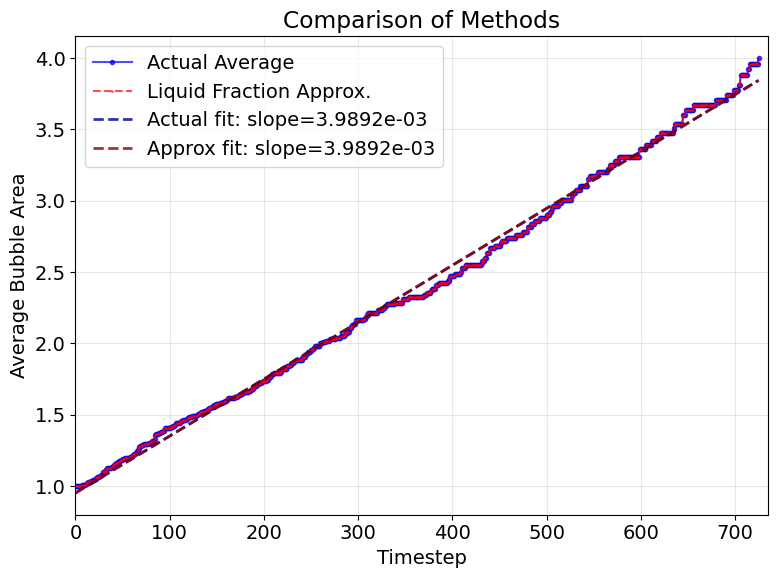

Slope comparison:
Actual average area slope: 3.989192e-03
Approximated area slope: 3.989192e-03
Slope ratio (Actual/Approx): 1.000


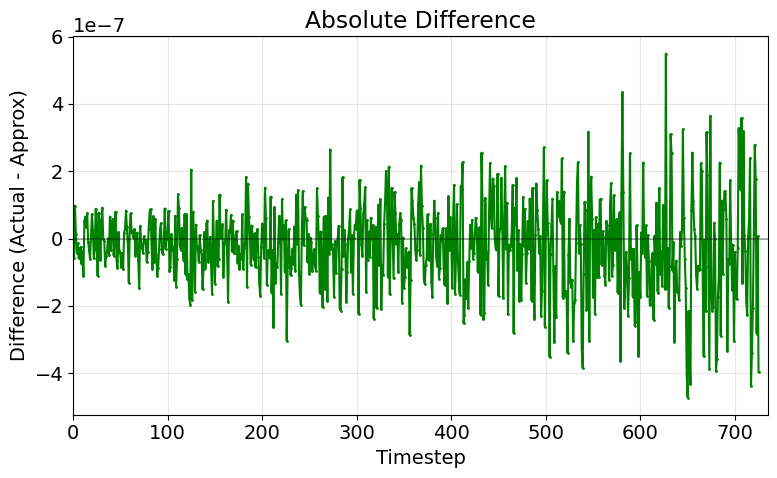

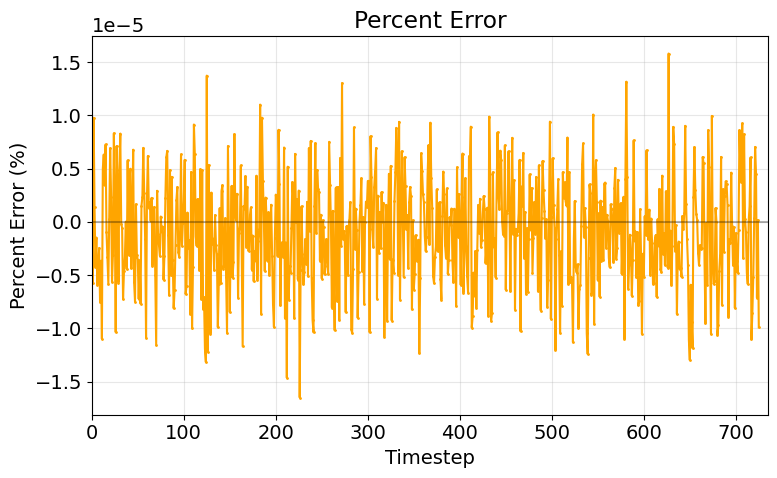


Summary comparison:
Initial actual average area: 1.000000
Initial approximated area: 1.000000
Initial error: -0.000000 (-0.00%)
Final actual average area: 4.000000
Final approximated area: 4.000000
Final error: -0.000000 (-0.00%)


In [ ]:
# wetfoam2_bub_RH2_0.020000_0.507713.dat
# try with different data file

# Compare with liquid fraction approximation method
liquid_fraction = 0.02
box_area = 20.203051 ** 2 

# Number of unique bubbles per timestep
bubbles_per_timestep = df_corrected.groupby("timestep")["id"].nunique()

# Approximate average area using liquid fraction
approx_avg_area = (box_area * (1 - liquid_fraction)) / bubbles_per_timestep
print(approx_avg_area[0])

# print(f"Bubbles per timestep:\n{bubbles_per_timestep} \n")  # check if numbers are correct

# Calculate the difference between methods
difference = avg_area_per_timestep - approx_avg_area
percent_error = (difference / avg_area_per_timestep) * 100

print(f"Box area: {box_area:.2f}")
print(f"Assumed liquid fraction: {liquid_fraction:.2f}")
print(f"Mean percent error: {np.mean(percent_error):.2f}%")
print(f"Standard deviation of percent error: {np.std(percent_error):.2f}%")

# Plot comparison
plt.figure(figsize=(8, 6))

# Calculate linear fits for both methods
slope_actual, intercept_actual, _, _, _ = linregress(avg_area_per_timestep.index, avg_area_per_timestep.values)
slope_approx, intercept_approx, _, _, _ = linregress(approx_avg_area.index, approx_avg_area.values)

# Plot actual average area with blue circles
plt.plot(avg_area_per_timestep.index, avg_area_per_timestep.values, 
         marker='o', markersize=3, linestyle='-', alpha=0.7, color='blue', label='Actual Average')

# Plot approximation with red triangles
plt.plot(approx_avg_area.index, approx_avg_area.values, 
         marker='^', markersize=1, linestyle='--', alpha=0.7, color='red', label='Liquid Fraction Approx.')

# Add linear fits
plt.plot(avg_area_per_timestep.index, intercept_actual + slope_actual * avg_area_per_timestep.index, 
         '--', alpha=0.8, color='darkblue', linewidth=2, label=f'Actual fit: slope={slope_actual:.4e}')
plt.plot(approx_avg_area.index, intercept_approx + slope_approx * approx_avg_area.index, 
         '--', alpha=0.8, color='darkred', linewidth=2, label=f'Approx fit: slope={slope_approx:.4e}')

plt.xlabel("Timestep")
plt.ylabel("Average Bubble Area")
plt.title("Comparison of Methods")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, avg_area_per_timestep.index.max()+10)
plt.tight_layout()
plt.savefig("/Users/conorkirby/projects/python/Capstone/Figures/comparison_bubble_area_methods.png", dpi=300)
plt.show()

print(f"Slope comparison:")
print(f"Actual average area slope: {slope_actual:.6e}")
print(f"Approximated area slope: {slope_approx:.6e}")
print(f"Slope ratio (Actual/Approx): {slope_actual/slope_approx:.3f}")

# Absolute difference
plt.figure(figsize=(8, 5))
plt.plot(difference.index, difference.values, marker='o', markersize=1, color='green')
plt.xlabel("Timestep")
plt.ylabel("Difference (Actual - Approx)")
plt.title("Absolute Difference")
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.xlim(0, avg_area_per_timestep.index.max()+10)
plt.savefig("/Users/conorkirby/projects/python/Capstone/Figures/absolute_difference_bubble_area_methods.png", dpi=300)
plt.show()

# Percent error
plt.figure(figsize=(8, 5))
plt.plot(percent_error.index, percent_error.values, marker='o', markersize=1, color='orange')
plt.xlabel("Timestep")
plt.ylabel("Percent Error (%)")
plt.title("Percent Error")
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.xlim(0, avg_area_per_timestep.index.max()+10)
plt.savefig("/Users/conorkirby/projects/python/Capstone/Figures/percent_error_bubble_area_methods.png", dpi=300)
plt.show()

# Summary statistics
print(f"\nSummary comparison:")
print(f"Initial actual average area: {A_0:.6f}")
print(f"Initial approximated area: {approx_avg_area.iloc[0]:.6f}")
print(f"Initial error: {difference.iloc[0]:.6f} ({percent_error.iloc[0]:.2f}%)")
print(f"Final actual average area: {avg_area_per_timestep.iloc[-1]:.6f}")
print(f"Final approximated area: {approx_avg_area.iloc[-1]:.6f}")
print(f"Final error: {difference.iloc[-1]:.6f} ({percent_error.iloc[-1]:.2f}%)")

# Mean Squared Displacement (MSD) Analysis

This section analyzes the mean squared displacement (MSD) of bubbles over time to quantify their diffusive motion. The MSD is calculated for each timestep as the average squared distance each bubble has moved from its initial position. This provides insight into the collective dynamics and effective diffusion properties of the bubble system. Key milestones, such as significant reductions in bubble count, are also highlighted to correlate changes in MSD with system evolution.

In [ ]:
# Mean squared displacement analysis

# Reuse variables from last cell
max_timestep = df_corrected["timestep"].max()
print(f"Maximum timestep: {max_timestep}")

initial_bubble_count = bubbles_per_timestep.iloc[0]
print(f"Initial number of bubbles: {initial_bubble_count}")

# Find timesteps where significant bubble losses occur
milestone_counts = [300, 200, 125]
milestone_timesteps = {}

for count in milestone_counts:
    mask = bubbles_per_timestep <= count
    if mask.any():
        milestone_timesteps[count] = bubbles_per_timestep[mask].index[0]
    else:
        milestone_timesteps[count] = None

print("Milestone timesteps:")
for count, timestep in milestone_timesteps.items():
    if timestep is not None:
        print(f"  {count} bubbles left at timestep {timestep}")
    else:
        print(f"  Never reached {count} bubbles")

# A_0 initial average bubble area 
print(f"Initial average bubble area <A_0>: {A_0:.6f}")


Maximum timestep: 725
Initial number of bubbles: 400
Milestone timesteps:
  300 bubbles left at timestep 85
  200 bubbles left at timestep 260
  125 bubbles left at timestep 555
Initial average bubble area <A_0>: 1.000000


In [ ]:

# Calculate MSD for each timestep
timesteps = np.arange(0, max_timestep + 1)
msd_values = []
bubble_counts = []

for t in timesteps:
    # Get all bubbles that exist at timestep t
    bubbles_at_t = df_corrected[df_corrected["timestep"] == t]
    
    if len(bubbles_at_t) == 0:
        msd_values.append(np.nan)
        bubble_counts.append(0)
        continue
    
    # Calculate squared displacement from initial position for each bubble
    squared_displacements = []
    
    for bubble_id in bubbles_at_t["id"].unique():
        # Get all positions for this bubble up to timestep t
        bubble_data = df_corrected[
            (df_corrected["id"] == bubble_id) & 
            (df_corrected["timestep"] <= t)
        ].sort_values("timestep")
        
        if len(bubble_data) < 2:  # Need at least initial position
            continue
            
        # Get initial and current positions
        x_initial = bubble_data["x"].iloc[0]
        y_initial = bubble_data["y"].iloc[0]
        x_current = bubble_data["x"].iloc[-1]
        y_current = bubble_data["y"].iloc[-1]
        
        # Calculate squared displacement from initial position
        dx = x_current - x_initial
        dy = y_current - y_initial
        r_squared = dx**2 + dy**2
        
        squared_displacements.append(r_squared)
    
    if squared_displacements: # only if we have valid displacements
        msd_values.append(np.mean(squared_displacements))
        bubble_counts.append(len(squared_displacements))
    else:
        msd_values.append(np.nan) # no valid bubbles
        bubble_counts.append(0)

msd_values = np.array(msd_values)
bubble_counts = np.array(bubble_counts)

# Remove NaN values for plotting
valid_mask = ~np.isnan(msd_values)
timesteps_valid = timesteps[valid_mask]
msd_valid = msd_values[valid_mask]
counts_valid = bubble_counts[valid_mask]

print(f"Valid timesteps for MSD: {len(timesteps_valid)}")


Valid timesteps for MSD: 725


Slope of averaged MSD: 0.0007899255898805862


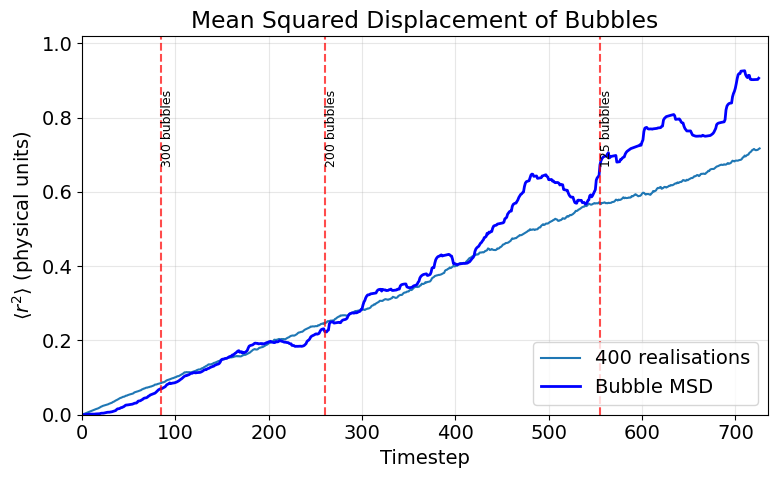

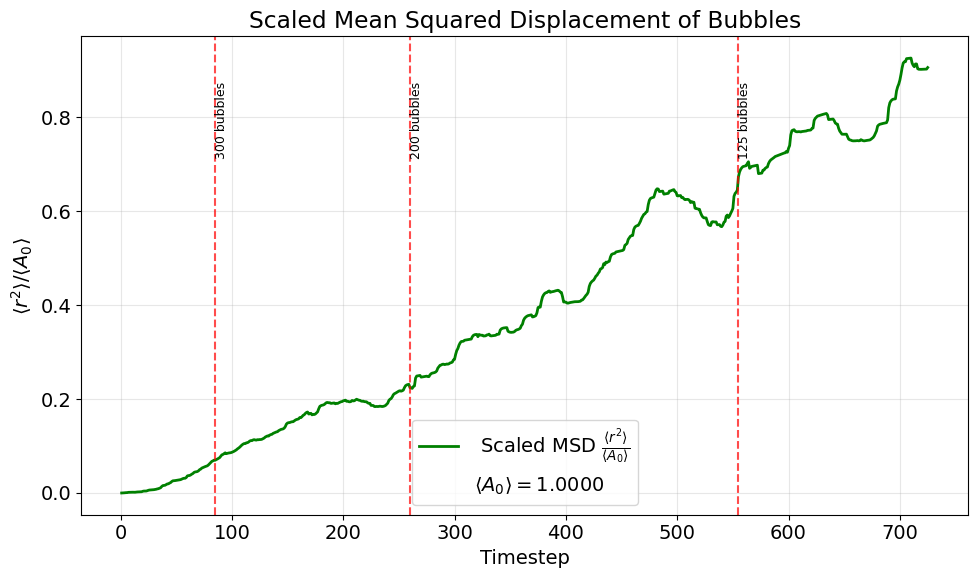

<Figure size 800x500 with 0 Axes>

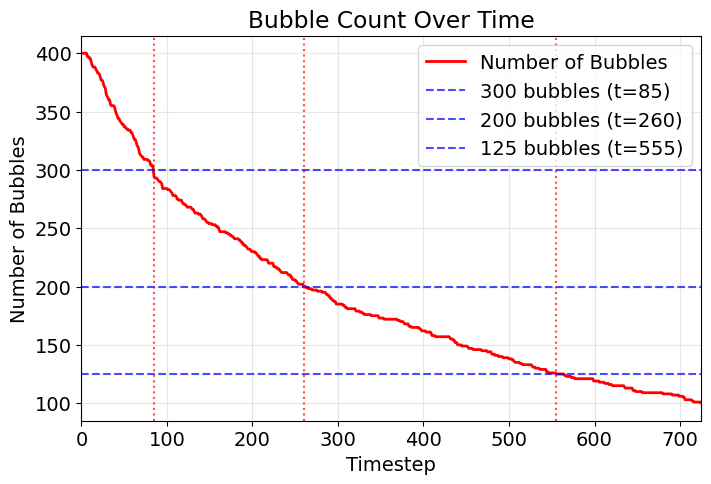

In [ ]:


num_steps = 726
num_walks = 400
std_dev = 0.02 # worth noting it is too random to analyse properly with std_dev over 0.5
box_size = 20.203051
scale = 0.5 # scaling for start and end points

# Store squared displacements
squared_displacements = np.zeros((num_walks, num_steps+1))

grid_size = int(np.sqrt(num_walks))                 # 20 x 20 grid = 400 walks
x_grid = np.linspace(0, box_size, grid_size)
y_grid = np.linspace(0, box_size, grid_size)
start_positions = np.array([(x, y) for x in x_grid for y in y_grid])

for w in range(num_walks):
    steps_x = np.random.normal(0, std_dev, num_steps) # when choosing these steps we are in tern choosing velocities
    steps_y = np.random.normal(0, std_dev, num_steps)

    x_positions = np.insert(np.cumsum(steps_x), 0, 0)
    y_positions = np.insert(np.cumsum(steps_y), 0, 0)

    squared_displacements[w] = x_positions**2 + y_positions**2

    x_positions += start_positions[w, 0]
    y_positions += start_positions[w, 1]

# Average over walks
msd = squared_displacements.mean(axis=0)
slope = (msd[-1] - msd[0]) / (num_steps - 0)
print(f"Slope of averaged MSD: {slope}")

plt.figure(figsize=(8, 5))  # Create new figure with specific size
plt.plot((msd/std_dev**2)/2000, label=r"400 realisations")            # msd/(v0**2 t0**2)

# Plot MSD with different scaling options

# Plot 1: MSD in physical units
plt.plot(timesteps_valid, msd_valid, 'b-', linewidth=2, label='Bubble MSD')
plt.xlabel('Timestep')
plt.ylabel(r'$\langle r^2 \rangle$ (physical units)')
plt.title('Mean Squared Displacement of Bubbles')
plt.grid(True, alpha=0.3)

# Add vertical lines for milestone bubble counts
for count, timestep in milestone_timesteps.items():
    if timestep is not None and timestep <= max_timestep:
        plt.axvline(x=timestep, color='red', linestyle='--', alpha=0.7)
        plt.text(timestep, plt.gca().get_ylim()[1] * 0.9, f'{count} bubbles', 
                 rotation=90, verticalalignment='top', fontsize=9)

plt.legend()
plt.tight_layout()
plt.xlim(0, max_timestep+10)
plt.ylim(0, msd_valid.max()*1.1)
#plt.savefig("/Users/conorkirby/projects/python/Capstone/Figures/bubble_MSD_alongside_Gaussian400.png", dpi=300, bbox_inches='tight')
plt.show()


# Plot 2: MSD scaled by initial average bubble area

plt.figure(figsize=(10, 6))
msd_scaled = msd_valid / A_0
plt.plot(timesteps_valid, msd_scaled, 'g-', linewidth=2, 
         label=r' Scaled MSD $\frac{\langle r^2 \rangle}{\langle A_0 \rangle}$')
plt.plot([], [], ' ', label=fr'$\langle A_0 \rangle={A_0:.4f}$')  # Empty plot for A0 value in legend
plt.xlabel('Timestep')
plt.ylabel(r'$\langle r^2 \rangle / \langle A_0 \rangle$')
plt.title('Scaled Mean Squared Displacement of Bubbles')
plt.grid(True, alpha=0.3)

# Add vertical lines for milestone bubble counts
for count, timestep in milestone_timesteps.items():
    if timestep is not None and timestep <= max_timestep:
        plt.axvline(x=timestep, color='red', linestyle='--', alpha=0.7)
        plt.text(timestep, plt.gca().get_ylim()[1] * 0.9, f'{count} bubbles', 
                 rotation=90, verticalalignment='top', fontsize=9)

plt.legend()
plt.tight_layout()
plt.figure(figsize=(8,5))
#plt.savefig("/Users/conorkirby/projects/python/Capstone/Figures/bubble_MSD_analysis.png", dpi=300)
plt.show()



# Plot 3: Bubble count vs timestep to visualize disappearance

plt.figure(figsize=(8, 5))
plt.plot(timesteps_valid, counts_valid, 'r-', linewidth=2, label='Number of Bubbles')
plt.xlabel('Timestep')
plt.ylabel('Number of Bubbles')
plt.title('Bubble Count Over Time')
plt.grid(True, alpha=0.3)

# Add horizontal lines for milestones with timestep information in label
for count, timestep in milestone_timesteps.items():
    if timestep is not None:
        plt.axhline(y=count, color='blue', linestyle='--', alpha=0.7, 
                   label=f'{count} bubbles (t={timestep})')
    
# Add vertical lines at milestone timesteps
for count, timestep in milestone_timesteps.items():
    if timestep is not None:
        plt.axvline(x=timestep, color='red', linestyle=':', alpha=0.7)

plt.legend()
plt.xlim(0, max_timestep)
#plt.savefig("/Users/conorkirby/projects/python/Capstone/Figures/bubble(MSD)_count_over_time.png", dpi=300)
plt.show()



MSD Analysis Results:
MSD slope (early timesteps): 1.083316e-03
Effective diffusion coefficient: 2.708289e-04
R-squared: 0.9897


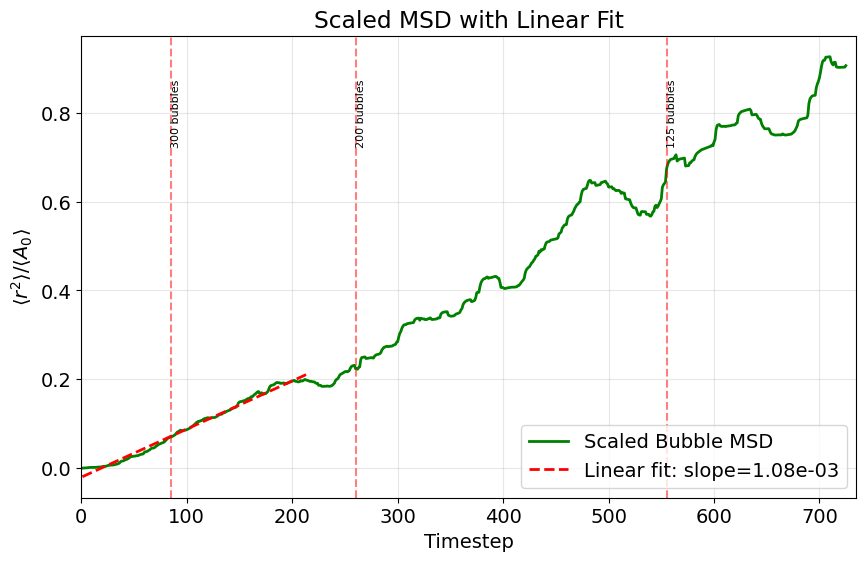

In [ ]:
# Calculate effective diffusion coefficient from MSD slope

# For the early part of the simulation where bubble count is higher 
if len(timesteps_valid) > 10:
    # Use first 30% of data for linear fit
    fit_end = int(0.3 * len(timesteps_valid))
    t_fit = timesteps_valid[:fit_end]
    msd_fit = msd_valid[:fit_end]
    
    if len(t_fit) > 5:
        slope_msd, intercept_msd, r_value, p_value, std_err = linregress(t_fit, msd_fit)
        D_eff = slope_msd / 4  # In 2D, MSD = 4*D*t
        
        print(f"\nMSD Analysis Results:")
        print(f"MSD slope (early timesteps): {slope_msd:.6e}")
        print(f"Effective diffusion coefficient: {D_eff:.6e}")
        print(f"R-squared: {r_value**2:.4f}")
        
        # Add fitted line to scaled plot
        plt.figure(figsize=(10, 6))
        plt.plot(timesteps_valid, msd_scaled, 'g-', linewidth=2, label='Scaled Bubble MSD')
        
        # Plot fitted line
        msd_fit_scaled = msd_fit / A_0
        plt.plot(t_fit, (intercept_msd + slope_msd * t_fit) / A_0, 'r--', linewidth=2, 
                label=f'Linear fit: slope={slope_msd/A_0:.2e}')
        
        plt.xlabel('Timestep')
        plt.ylabel(r'$\langle r^2 \rangle / \langle A_0 \rangle$')
        plt.title('Scaled MSD with Linear Fit')
        plt.grid(True, alpha=0.3)
        
        # Add milestone lines
        for count, timestep in milestone_timesteps.items():
            if timestep is not None and timestep <= max_timestep:
                plt.axvline(x=timestep, color='red', linestyle='--', alpha=0.5)
                plt.text(timestep, plt.gca().get_ylim()[1] * 0.9, f'{count} bubbles', 
                        rotation=90, verticalalignment='top', fontsize=8)
        
        plt.legend()
        plt.xlim(0, max_timestep+10)
        #plt.savefig("/Users/conorkirby/projects/python/Capstone/Figures/bubble_MSD_scaled_with_fit.png", dpi=300)
        plt.show()

# Coordination Number Z

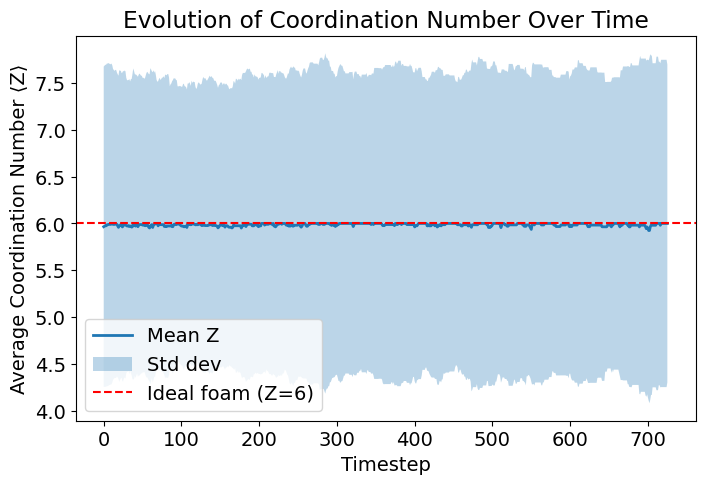

In [ ]:
# Average coordination number over time


Z_mean = df.groupby("timestep")["Z"].mean()
Z_std = df.groupby("timestep")["Z"].std()

plt.figure(figsize=(8,5))
plt.plot(Z_mean.index, Z_mean, label='Mean Z', lw=2)
plt.fill_between(Z_mean.index, Z_mean-Z_std, Z_mean+Z_std, alpha=0.3, label='Std dev')
plt.axhline(6, color='r', ls='--', label='Ideal foam (Z=6)', markersize=0.05)
plt.xlabel("Timestep")
plt.ylabel("Average Coordination Number ⟨Z⟩")
plt.legend()
plt.title("Evolution of Coordination Number Over Time")
plt.show()

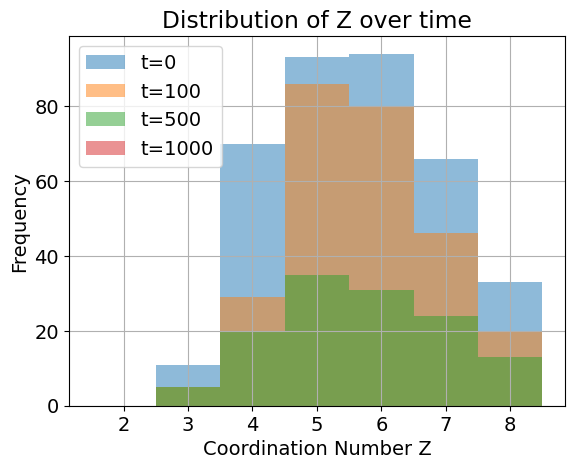

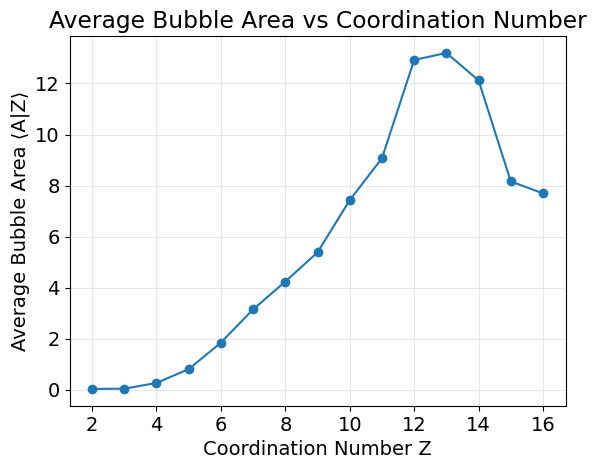

In [ ]:
# Plot Z distribution at a few representative times
timesteps = [0, 100, 500, 1000]
for t in timesteps:
    df_corrected[df_corrected["timestep"] == t]["Z"].hist(alpha=0.5, bins=np.arange(2, 10)-0.5, label=f't={t}')
plt.xlabel("Coordination Number Z")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribution of Z over time")
plt.show()

# Relationship between Z and bubble area (area is radius, so convert to actual area)
z_area_relation = df_corrected.groupby("Z")["area"].apply(lambda x: (np.pi * x**2).mean())
z_area_relation.plot(marker='o')
plt.xlabel("Coordination Number Z")
plt.ylabel("Average Bubble Area ⟨A|Z⟩")
plt.title("Average Bubble Area vs Coordination Number")
plt.grid(True, alpha=0.3)
plt.show()

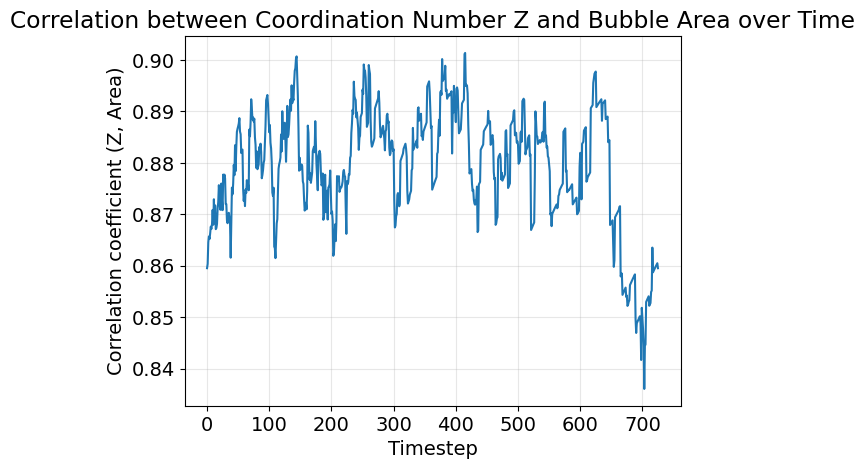

In [ ]:
# Calculate correlation between Z and area over time
# Note: area column contains radius values, so actual area = π * radius²
df_corrected['actual_area'] = np.pi * df_corrected['area']**2

corrs = df_corrected.groupby("timestep")[["Z", "actual_area"]].corr().iloc[0::2, -1]
plt.plot(corrs.index.get_level_values(0), corrs.values)
plt.xlabel("Timestep")
plt.ylabel("Correlation coefficient (Z, Area)")
plt.title("Correlation between Coordination Number Z and Bubble Area over Time")
plt.grid(True, alpha=0.3)
plt.show()

# Magnitude of consecutive step sizes

In [ ]:

# Compute step size per bubble
def compute_step_sizes(df):
    step_records = []
    for bubble_id, g in df.groupby("id"):
        g = g.sort_values("timestep").copy()
        x, y, t = g["x"].to_numpy(), g["y"].to_numpy(), g["timestep"].to_numpy()

        # compute differences
        dx, dy = np.diff(x), np.diff(y)
        s = np.sqrt(dx**2 + dy**2)

        step_records.append(pd.DataFrame({
            "id": bubble_id,
            "timestep": t[:-1],  # step between t and t+1
            "step_size": s
        }))

    return pd.concat(step_records, ignore_index=True)

df_steps = compute_step_sizes(df)

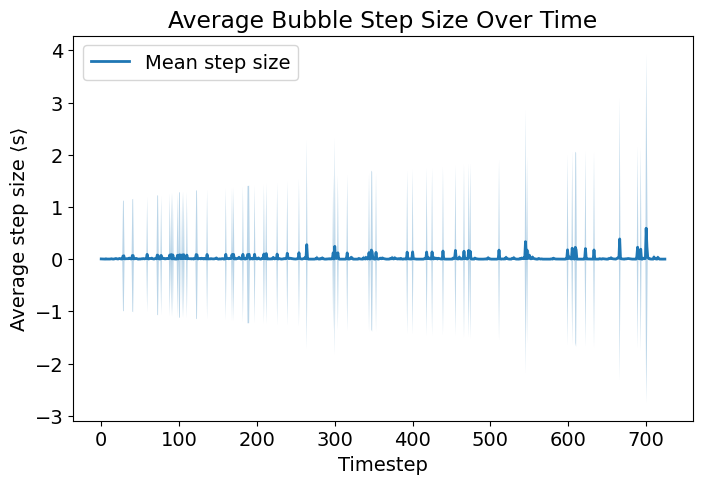

In [ ]:
step_mean = df_steps.groupby("timestep")["step_size"].mean()
step_std  = df_steps.groupby("timestep")["step_size"].std()

plt.figure(figsize=(8,5))
plt.plot(step_mean.index, step_mean, lw=2, label="Mean step size")
plt.fill_between(step_mean.index, step_mean-step_std, step_mean+step_std, alpha=0.3)
plt.xlabel("Timestep")
plt.ylabel("Average step size ⟨s⟩")
plt.title("Average Bubble Step Size Over Time")
plt.legend()
plt.show()

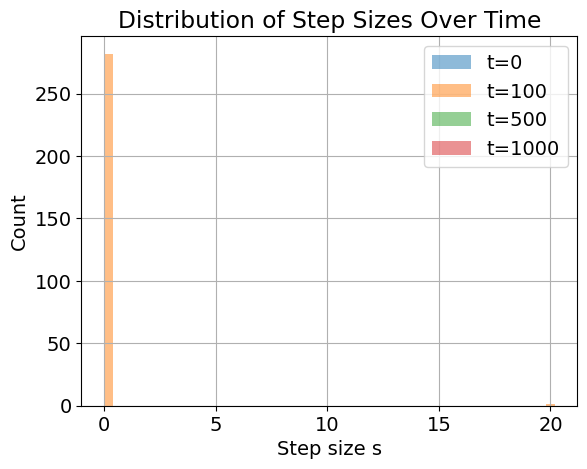

In [ ]:
timesteps = [0, 100, 500, 1000]
for t in timesteps:
    df_steps[df_steps["timestep"] == t]["step_size"].hist(
        bins=50, alpha=0.5, label=f"t={t}")
plt.xlabel("Step size s")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of Step Sizes Over Time")
plt.show()

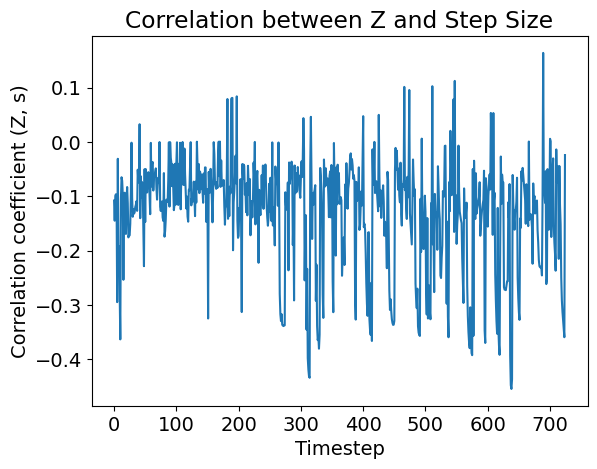

In [ ]:
# Merge Z from main df (same timestep and id)
df_merged = pd.merge(df_steps, df[["id", "timestep", "Z"]], on=["id", "timestep"], how="left")

# Average step size per Z at each timestep (optional)
corrs = df_merged.groupby("timestep")[["Z", "step_size"]].corr().iloc[0::2, -1]
plt.plot(corrs.index.get_level_values(0), corrs.values)
plt.title("Correlation between Z and Step Size")
plt.xlabel("Timestep")
plt.ylabel("Correlation coefficient (Z, s)")
plt.show()

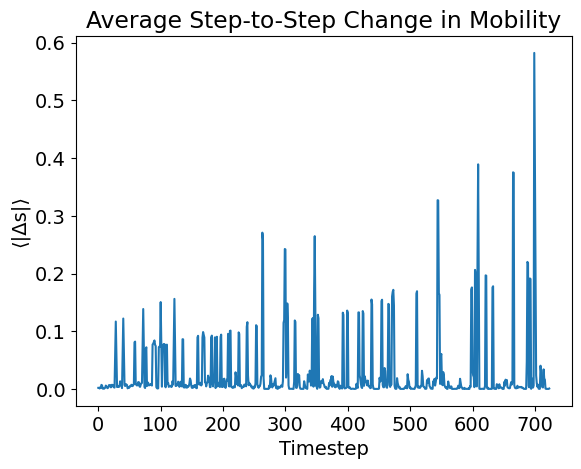

In [ ]:
def compute_step_differences(df_steps):
    diffs = []
    for bubble_id, g in df_steps.groupby("id"):
        g = g.sort_values("timestep").copy()
        ds = np.diff(g["step_size"])
        diffs.append(pd.DataFrame({
            "id": bubble_id,
            "timestep": g["timestep"].iloc[:-1],
            "ds": ds
        }))
    return pd.concat(diffs, ignore_index=True)

df_diffs = compute_step_differences(df_steps)

# Plot mean absolute change in step size
mean_ds = df_diffs.groupby("timestep")["ds"].apply(lambda x: np.mean(np.abs(x)))
plt.plot(mean_ds.index, mean_ds)
plt.title("Average Step-to-Step Change in Mobility")
plt.xlabel("Timestep")
plt.ylabel("⟨|Δs|⟩")
plt.show()